### imports and functions

In [62]:
import scipy.io as sio
import numpy as np
from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler,Normalizer,QuantileTransformer
from keras.models import Model
from keras.layers import Dense,Input
import pandas as pd
from sklearn.metrics.pairwise import *
import matlab
import matlab.engine
from scipy.stats import *
from scipy.spatial.distance import *
from scipy.sparse.csgraph import laplacian
from numpy.linalg import eig
import hdbscan

import rcc
from sklearn.decomposition import *
import keras.backend as K
from scipy.spatial.distance import *
from sklearn.neighbors import *

from keras.optimizers import *
from sklearn.model_selection import *
from keras.layers import Lambda,Dropout,Embedding
from keras.utils import multi_gpu_model
from keras import regularizers
from IPython.display import SVG
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import consensus_score
from sklearn import metrics
import scipy.cluster.hierarchy as hc
from sklearn.metrics import *
from keras.utils.vis_utils import model_to_dot
import os
import seaborn as sns
from sklearn.manifold import TSNE,Isomap,LocallyLinearEmbedding
import umap
from scipy.cluster.hierarchy import *
from sklearn.cluster import *
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.constraints import *
from keras.regularizers import *
from keras.layers import *

from keras.initializers import *
activa = 'relu'
dp_rate = 0.5
low_dim = 128
l2_penalty = 0
l1_penalty = 1e-5
os.environ["CUDA_VISIBLE_DEVICES"]="1"


# num_features = 286
num_features = 274
img_size = 256
def majorvote_clustering(pixel_data,pixel_belonging,k,norm=False):
    num_cells = np.max(cell_idx)
    pixel_cluster_label = KMeans(n_clusters=k).fit_predict(pixel_data)
    tmp,pixel_label_count = np.unique(pixel_cluster_label,return_counts=True)
    rst = []
    for ith_cell in range(num_cells):
        ith_cell+=1
        label_count = np.zeros(shape=(k,))
        unique_labels,label_count_tmp = np.unique(pixel_cluster_label[pixel_belonging==ith_cell],return_counts=True)
        label_count[unique_labels] = label_count_tmp
        if norm==True:
            label_count = label_count/pixel_label_count
        rst.append(np.argmax(label_count))
    return np.array(rst)

def reset_weights(model):
    session = K.get_session()
#     k=0
    for layer in model.layers: 
#         print(k)
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
#             k+=1

def label2CM(label):
    label_sz = label.shape[0]
    rst = np.zeros(shape=(label_sz,label_sz))
    for i in range(label_sz):
        for j in range(i+1):
            if label[i]<0 or label[j]<0:
                continue
            if label[i]==label[j]:
                rst[i,j] = 1
                rst[j,i] = 1
    return rst
            
def get_matter_img(matter_idx,batch_num):
    data = batch_dict[batch_num]
    pos = pos_dict[batch_num]
    sorted_idx = np.argsort(pos)
    sorted_data = data[sorted_idx,matter_idx]
    return sorted_data.reshape((256,256))

def ind2ij(ind,size,axis):
    i,j=divmod(ind-1,size)
    i+=1
    j+=1
    return np.array([i,j])[axis]

def cal_square_dist(idx1,idx2,size):
    i1,j1=divmod(idx1-1,size)
    i1 +=1
    j1 +=1
    i2,j2=divmod(idx2-1,size)
    i2+=1
    j2+=1
    return (i1-i2)**2+(j1-j2)**2
def get_labeling(label,cell_idx):
#     y是cell-rela的细胞对应的标签
#     print('pred_y',np.unique(label))
    labeling = np.zeros(shape=(65536,1))
    b = cell_idx.copy()
    num_cells = label.shape[0]
    for i in range(num_cells):
        b[b==i+1] = label[i] + 1
#     print(cell_pos)
#     print('b',np.unique(b))
#     cell_pos = cell_pos.astype('int')
    labeling[cell_pos.astype('int')-1,0] = b
    
    return labeling

def numpy2mat(numpy_mat):
    list_mat = list(map(lambda x:list(x),numpy_mat))
    return matlab.double(list_mat)
def SIMLR(data_x,k):
    data_x = numpy2mat(data_x)
    [cur_label, S, F, ydata,alphaK,timeOurs,converge,LF] = eng.SIMLR(data_x,k,10.0,nargout=8)
    y_SIMLR = np.array(cur_label)[:,0]
    return y_SIMLR

def SC3(data_x,k,transformations=['PCA']):
    # data_x = rep
    # k=3
    # transformations = ['PCA','Laplacian']
    k = int(k)
    d_range_low = np.max([np.floor(data_x.shape[0]*0.04),1])
    d_range_high = np.ceil(data_x.shape[0]*0.07)
    d_range = np.arange(d_range_low,d_range_high+1)
    distance_metrics = ['euclidean','pearson','spearman']
    kmeans_input_pool = []
    kmeans_label_list = []
    CM = np.zeros(shape=(data_x.shape[0],data_x.shape[0]))
    for distance_metric in distance_metrics:
        if distance_metric=='euclidean':
            dist_mat = squareform(pdist(data_x,'euclidean'))
        elif distance_metric=='pearson':
            dist_mat = squareform(pdist(data_x,'correlation'))
        elif distance_metric=='spearman':
            dist_mat = 1-spearmanr(np.transpose(data_x))[0]
        for transformation in transformations:
            if transformation=='PCA':
                trans_dist_mat = PCA(n_components=int(d_range_high)).fit_transform(dist_mat)
            elif transformation=='Laplacian':
                simi_mat = np.exp(-dist_mat/(np.max(dist_mat)))
                graph_lap = laplacian(simi_mat,normed=True,return_diag=False)
                eig_value,eig_vector = eig(graph_lap)
                trans_dist_mat = eig_vector[:,np.flip(np.argsort(eig_value),axis=0)[0:int(d_range_high)]]
            for d in d_range:
                cur_input = trans_dist_mat[:,0:int(d)]
                kmeans_input_pool.append(cur_input)
    for kmeans_input in kmeans_input_pool:
        cur_y = KMeans(k).fit_predict(kmeans_input)
        kmeans_label_list.append(cur_y)
        cur_CM = label2CM(cur_y)
        CM = CM + cur_CM
    CM = CM/np.max(CM)
    y_SC3=AgglomerativeClustering(n_clusters=k,affinity='precomputed',linkage='complete').fit_predict(1-CM)

    return y_SC3


### prepare data

In [ ]:
# mixed cell line
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_0928hunyang_2batch.mat')

# mixed cell line
# data_mat = sio.loadmat('/home/yzy/SIMS/datamat_1001cellline_4batch_last2dimbri.mat')



# data_mat = sio.loadmat('/home/yzy/SIMS/0713liver_data.mat')

data_mat=data_mat['data_mat']


In [2]:

from sklearn.metrics.pairwise import euclidean_distances
import pickle
batch_dict = {}
batch_dict_robust = {}
batch_dict_minmax = {}
batch_dict_standard = {}
batch_dict_134 = {}
batch_dict_norm = {}
batch_dict_norm_standard = {}
batch_dict_standard_norm = {}
label_dict = {}
cell_dict = {}
pos_dict = {}
cell_weight_dict = {}
FE_dict={}
for i in range(4):
    print(i)
    cur_data = data_mat[data_mat[:,0]==i+1,4:num_features+4]
    cur_data_134 = cur_data/cur_data[:,96-2][:,None]
    cur_data_robust = RobustScaler().fit_transform(cur_data)
    cur_data_minmax = MinMaxScaler().fit_transform(cur_data)
    cur_data_standard = StandardScaler().fit_transform(cur_data)
    cur_data_norm = Normalizer().fit_transform(cur_data)
    cur_data_norm_standard = StandardScaler().fit_transform(cur_data_norm)
    cur_data_standard_norm = Normalizer().fit_transform(cur_data_standard)
    batch_dict[i+1] = cur_data
    batch_dict_134[i+1] = cur_data_134
    batch_dict_robust[i+1] = cur_data_robust
    batch_dict_minmax[i+1] = cur_data_minmax
    batch_dict_standard[i+1] = cur_data_standard
    batch_dict_norm[i+1] = cur_data_norm
    batch_dict_norm_standard[i+1] = cur_data_norm_standard
    batch_dict_standard_norm[i+1] = cur_data_standard_norm
    label_dict[i+1] = data_mat[data_mat[:,0]==i+1,2]
    cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
    cur_batch_idx = data_mat[data_mat[:,0]==i+1,3]
#     FE_dict[i+1] = data_mat[data_mat[:,0]==i+1,4]
    pos_dict[i+1] = cur_batch_idx


0


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


1
2
3


### simulation function

In [3]:
def simulate_data(batch_idx,mode,fold_var,mean_shift,change_dims):
    cell_idx = cell_dict[batch_idx]
    sample_x = batch_dict[batch_idx]
    sample_x_rst = sample_x.copy().astype('float64')
    cell_idx_rst = cell_idx.copy()
    if mode==0:
        
        sample_x_rst = sample_x
    elif mode==1:
#         rendomly choose change_dims dimentions, and resample every cells' profile with N(mean_shift,fold_var)
#         fold_var,mean_shift,change_dims
        selected_dims = np.random.permutation(sample_x.shape[1])[0:change_dims]
        for i in range(np.max(cell_idx)):
            cur_cell = sample_x[cell_idx==i+1,:]

            for j in selected_dims:
#                 print(i,j)
                cur_cell_mean = np.mean(cur_cell[:,j])+mean_shift
                cur_cell_std = np.std(cur_cell[:,j])*fold_var
                
                cur_simu = np.random.normal((cur_cell_mean), (cur_cell_std), cur_cell.shape[0])
                for k in range(10):
                    if np.min(cur_simu)>=0:
                        break
                    cur_simu = np.random.normal((cur_cell_mean), (cur_cell_std), cur_cell.shape[0])
                if np.min(cur_simu)<0:
                    cur_simu = cur_cell[:,j]
                else:
                    pass
                    
                sample_x_rst[cell_idx==i+1,j] = cur_simu
    elif mode==2:
#         add pixels for every cells
#         fold_var: added intensity
#         mean_shift: added pixel propotion

        selected_dims = np.random.permutation(sample_x.shape[1])[0:change_dims]
        
        for i in range(np.max(cell_idx)):
            cur_area = np.sum(cell_idx==i+1)
            cur_add_num = int(cur_area*mean_shift)+1
            sample_x_rst = np.vstack([sample_x_rst,fold_var*np.ones(shape=(cur_add_num,sample_x.shape[1]))])
            cell_idx_rst = np.hstack([cell_idx_rst,(i+1)*np.ones(shape=(cur_add_num,))])
            cell_idx_rst = cell_idx_rst.astype('int')

    elif mode==3:
#         for each cell, multiply "mean_shift" proportion pixels with "fold_var"
         
#         fold_var: multiply number
#         mean_shift: proportion
        for i in range(np.max(cell_idx)):
            cur_cell = sample_x[cell_idx==i+1,:]
            num_change = int(mean_shift*cur_cell.shape[0])
            selected_pixels_idx = np.random.permutation(cur_cell.shape[0])[0:num_change]
            changed_cell = cur_cell.copy()
            changed_cell[selected_pixels_idx,:] = changed_cell[selected_pixels_idx,:]*fold_var
            sample_x_rst[cell_idx==i+1,:] = changed_cell
    elif mode==4:
#         multiply pixels with uniform (0~fold_var)
        uniform_sample = np.random.uniform(0,fold_var,size=(sample_x.shape[0],1))
        sample_x_rst = sample_x_rst*uniform_sample
    elif mode==5:
#         randomly choose "change_dim" dimentions, multiply with fold_var
        selected_dims = np.random.permutation(sample_x.shape[1])[0:change_dims]
        sample_x_rst[:,selected_dims]*=fold_var
    elif mode==6:
#         multipy selected list of dimentions, multiply with fold_var
        for change_dim_idx in range(len(change_dims)):
            cur_change_dim = change_dims[change_dim_idx]
            cur_fold_change = fold_var[change_dim_idx]
            sample_x_rst[:,cur_change_dim]*=cur_fold_change
        

    return sample_x_rst,cell_idx_rst


def get_train_data(batch_num_list,mode,norm):
#     mode:'none','median','total'
#     norm:'none',standard','l1','l2'
#     batch_num_list = [3,5]
    # 5 lines
    # 1,2,3,4,5,6
    # batch_num = 4
    top_n_var = 250
    train_x_all = None
    cell_idx_all = None
    cell_type_all = None
    cell_pos_all = None
    batch_idx_all = None
    num_cells_all = 0


    for batch_num in batch_num_list:
        train_x = batch_dict[batch_num]

        cell_idx = cell_dict[batch_num]
        cell_type = label_dict[batch_num]
        cell_pos = pos_dict[batch_num]
        cell_related_ind = (cell_idx!=0)

        num_cells = int(np.max(cell_idx))
        train_x = train_x[cell_related_ind,:]

        cell_idx = cell_idx[cell_related_ind]
        cell_type = cell_type[cell_related_ind]
        cell_pos = cell_pos[cell_related_ind]





        var_li = []
        normed_var_li = []
        for i in range(train_x.shape[1]):
            cur_col = train_x[:,i]
        #     cur_col= cur_row/np.sum(cur_col)
        #     cur_entropy = entropy(cur_col)
            cur_var = np.var(cur_col)
            cur_normed_var = cur_var/np.mean(cur_col)
        #     entropy_li.append(cur_entropy)
            var_li.append(cur_var)
            normed_var_li.append(cur_normed_var)
        # entropy_li = np.array(entropy_li)
        var_li = np.array(var_li)
        normed_var_li = np.array(normed_var_li)
        sort_ind = np.flip(np.argsort(normed_var_li),axis=0)
        sort_val = np.flip(np.sort(normed_var_li),axis=0)

        if train_x_all is None:
            train_x_all = train_x
        else:
            train_x_all = np.vstack([train_x_all,train_x])
        if cell_idx_all is None:
            cell_idx_all = cell_idx
        else:
            cell_idx_all = np.hstack([cell_idx_all,cell_idx+np.max(cell_idx_all)])
        if cell_type_all is None:
            cell_type_all = cell_type
        else:
            cell_type_all = np.hstack([cell_type_all,cell_type])
        if cell_pos_all is None:
            cell_pos_all = cell_pos
        else:
            cell_pos_all = np.hstack([cell_pos_all,cell_pos])
        if batch_idx_all is None:
            batch_idx_all = batch_num*np.ones(shape=(cell_idx.shape))
        else:
            batch_idx_all = np.hstack([batch_idx_all,batch_num*np.ones(shape=(cell_idx.shape))])


    train_x = train_x_all
    cell_idx = cell_idx_all
    cell_type = cell_type_all
    cell_pos = cell_pos_all
    batch_idx = batch_idx_all
    num_cells = np.max(cell_idx)
    if mode=='none':
        train_x = train_x
    elif mode=='median':
        train_x = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
        train_x = np.log(train_x+1)
    elif mode=='total':
        train_x = train_x/np.sum(train_x,axis=1,keepdims=True)
        train_x = np.log(train_x+1)
    
    if norm=='standard':
        train_x = StandardScaler().fit_transform(train_x)
    elif norm=='l1':
        train_x = Normalizer(norm='l1').fit_transform(train_x)
    elif norm=='l2':
        train_x = Normalizer(norm='l2').fit_transform(train_x)
    elif norm=='none':
        train_x = train_x
    
    return train_x,cell_idx,cell_type,cell_pos,batch_idx,num_cells



### show data example

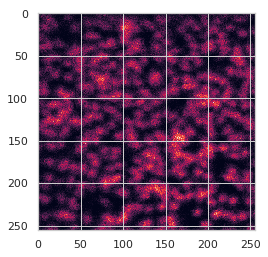

In [86]:
img =batch_dict[4][:,91][np.argsort(pos_dict[4])]
plt.imshow(img.reshape((256,256)))
plt.show()

### SIMS-ID main function


In [131]:
def get_distil_rep(train_x,num_cells,t_list,epochs=50,verbose=False,activa = 'relu',dp_rate = 0.5,low_dim = 128,l2_penalty = 0,l1_penalty = 1e-5,use_bias = False):
        ####################MLP################################################################################
    SIMS_input = Input(shape=(train_x.shape[1],))
    target_input = Input(shape=(1,))
    dummy_input = Input(shape=(num_cells,))

    d1 = Dense(512,activation=activa,kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty),use_bias=use_bias)(SIMS_input)
    # d1 = Dense(1024,activation=activa,kernel_initializer='random_uniform')(SIMS_input)
    # d1 = Dense(1024,activation=activa,kernel_initializer='random_uniform')(d1)


    d2 = Dense(256,activation=activa,kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty),use_bias=use_bias)(d1)
    # d2 = Dense(512,activation=activa,kernel_initializer='random_uniform')(d1)
    # d2 = Dense(512,activation=activa,kernel_initializer='random_uniform')(d2)
    # d2 = Dense(256,activation='linear',kernel_initializer='random_uniform',use_bias=use_bias)(d2)


    # d3 = Dense(64,activation=activa,kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty))(d2)
    # d3 = Dense(256,activation=activa,kernel_initializer='random_uniform')(d2)
    # d3 = Dense(256,activation=activa,kernel_initializer='random_uniform')(d3)


    d4 = Dense(low_dim,activation=activa,kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty),use_bias=use_bias)(d2)
    # d4 = Dense(num_cells,activation='linear',kernel_initializer=glorot_normal(),kernel_regularizer=l2(l2_penalty),use_bias=use_bias)(d2)
    ####################MLP################################################################################
    centerloss_embed_layer = Embedding(num_cells, low_dim)(target_input)
    centerloss_out = Lambda(lambda x: K.sum(K.square(x[0]-x[1][:,0]), 1, keepdims=True), name='center')([d4,centerloss_embed_layer])


    embed_layer = Embedding(num_cells,low_dim,input_length=num_cells,embeddings_initializer='random_uniform')(dummy_input)
    normalized_logit_layer = Lambda(modi_softmax,name='normalized_logit_layer')([d4,embed_layer])


    softmax_out = Activation('softmax',name='softmax')(normalized_logit_layer)

    softmax_model = Model([SIMS_input,target_input,dummy_input],[softmax_out,centerloss_out])
    softmax_model.compile(optimizer=sgd(),loss=['categorical_crossentropy',lambda y_true,y_pred:y_pred],loss_weights=[1,0])
    onehot_label = keras.utils.to_categorical(cell_idx-1,num_cells)
    
    reset_weights(softmax_model)
    dummy_input_data = np.tile(np.arange(num_cells),(train_x.shape[0],1))
    history=softmax_model.fit([train_x,cell_idx-1,dummy_input_data],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=epochs,shuffle=True,batch_size=64,verbose=verbose)

    
    while np.abs(history.history['loss'][-1]-np.max(history.history['loss']))<=2:
        print('error')
        reset_weights(softmax_model)
        history=softmax_model.fit([train_x,cell_idx-1,dummy_input_data],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=epochs,shuffle=True,batch_size=64,verbose=verbose)


    logit_model = Model([SIMS_input,dummy_input],normalized_logit_layer)
    pred_logit = logit_model.predict([train_x,dummy_input_data])
    rep_list = []
    for t in t_list:
        cur_representation = np.exp(pred_logit/t)
        cur_representation = cur_representation/np.sum(cur_representation,axis=1,keepdims=True)
        cur_representation = np.transpose(cur_representation)
        rep_list.append(cur_representation)
    return rep_list


### wrap clustering functions

In [69]:
def SC3(data_x,k,transformations=['PCA']):

    k = int(k)
    d_range_low = np.max([np.floor(data_x.shape[0]*0.04),1])
    d_range_high = np.ceil(data_x.shape[0]*0.07)
    d_range = np.arange(d_range_low,d_range_high+1)
    distance_metrics = ['euclidean','pearson','spearman']
    kmeans_input_pool = []
    kmeans_label_list = []
    CM = np.zeros(shape=(data_x.shape[0],data_x.shape[0]))
    for distance_metric in distance_metrics:
        if distance_metric=='euclidean':
            dist_mat = squareform(pdist(data_x,'euclidean'))
        elif distance_metric=='pearson':
            dist_mat = squareform(pdist(data_x,'correlation'))
        elif distance_metric=='spearman':
            dist_mat = 1-spearmanr(np.transpose(data_x))[0]
        for transformation in transformations:
            if transformation=='PCA':
                trans_dist_mat = PCA(n_components=int(d_range_high)).fit_transform(dist_mat)
            elif transformation=='Laplacian':
                simi_mat = np.exp(-dist_mat/(np.max(dist_mat)))
                graph_lap = laplacian(simi_mat,normed=True,return_diag=False)
                eig_value,eig_vector = eig(graph_lap)
                trans_dist_mat = eig_vector[:,np.flip(np.argsort(eig_value),axis=0)[0:int(d_range_high)]]
            for d in d_range:
                cur_input = trans_dist_mat[:,0:int(d)]
                kmeans_input_pool.append(cur_input)
                
                
    if k<-1:
#         如果k=0，就估计一个k,kmax为abs(k)
        silhouette_list = []
        kmax = np.abs(k)
        for ak in range(2,kmax+1):
            for kmeans_input in kmeans_input_pool:
                cur_y = KMeans(ak).fit_predict(kmeans_input)
#                 kmeans_label_list.append(cur_y)
                cur_CM = label2CM(cur_y)
                CM = CM + cur_CM
            CM = CM/np.max(CM)
            y_ak=AgglomerativeClustering(n_clusters=ak,affinity='precomputed',linkage='complete').fit_predict(1-CM)
            silhouette_list.append(silhouette_score(1-CM,metric='precomputed',labels = y_ak))
        silhouette_list = np.array(silhouette_list)
        opt_k = np.argmax(silhouette_list)+2
        y_SC3=AgglomerativeClustering(n_clusters=opt_k,affinity='precomputed',linkage='complete').fit_predict(1-CM)
    elif k>1:
        for kmeans_input in kmeans_input_pool:
            cur_y = KMeans(k).fit_predict(kmeans_input)
            kmeans_label_list.append(cur_y)
            cur_CM = label2CM(cur_y)
            CM = CM + cur_CM
        CM = CM/np.max(CM)
        y_SC3=AgglomerativeClustering(n_clusters=k,affinity='precomputed',linkage='complete').fit_predict(1-CM)
    else:
        print('k error')
        return None
    return y_SC3
def SIMLR(data_x,k):
    data_x = numpy2mat(data_x)
    if k<-1:
#         要估计k
        kmax = np.abs(k)
        ks = list(np.arange(2,kmax+1))
        ks = matlab.double(ks)
        [k1,k2]=eng.Estimate_Number_of_Clusters_SIMLR(data_x,ks,nargout=2)
        opt_k = np.argmax(np.array(k2))+2
    elif k>1:
        opt_k = k
    else:
        print('k error')
        return None
    opt_k = float(opt_k)
    [cur_label, S, F, ydata,alphaK,timeOurs,converge,LF] = eng.SIMLR(data_x,opt_k,10.0,nargout=8)
    y_SIMLR = np.array(cur_label)[:,0]
    return y_SIMLR

### comparisons

In [ ]:
from sklearn.svm import LinearSVC
fold_change_list = np.arange(0,2,0.02)
rst_dump_svm = {}
logit_list_dict = {}
for fold_change in fold_change_list:
#     fold_change = 2
    change_dims = [86]
    simu_base = 3

    batch_num_list = [simu_base,5]
    for i in range(4+1,len(batch_dict)+1):
        del batch_dict[i]
        del cell_dict[i]
        del label_dict[i]
        del pos_dict[i]

    cur_batch_num = len(batch_dict)
    simu_data_1,simu_cellidx = simulate_data(simu_base,6,fold_change,0,[61])
    batch_dict[cur_batch_num+1] = simu_data_1
    # batch_dict[cur_batch_num+1] = 111
    cell_dict[cur_batch_num+1] = simu_cellidx
    label_dict[cur_batch_num+1] =  (cur_batch_num+1)*np.ones(shape=(simu_data_1.shape[0],))
    pos_dict[cur_batch_num+1] = np.hstack([pos_dict[simu_base],1+np.arange(simu_data_1.shape[0]-pos_dict[simu_base].shape[0])])

    [train_x,cell_idx,cell_type,cell_pos,batch_idx,num_cells] = get_train_data(batch_num_list,'none','none')
    _,unique_idx = np.unique(cell_idx,return_index=True)
    true_y = cell_type[unique_idx]
    np.unique(true_y)

    # mean_total
    train_x_total = train_x/np.sum(train_x,axis=1,keepdims=True)
    train_x_total = np.log(train_x_total+1)
    mean_profile_list_total = []
    for i in range(num_cells):
        mean_profile_list_total.append(np.mean(train_x_total[cell_idx==i+1,:],axis=0))
    mean_profile_list_total = np.array(mean_profile_list_total)


    #mean median
    train_x_median = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
    train_x_median = np.log(train_x_median+1)
    mean_profile_list_median = []
    for i in range(num_cells):
        mean_profile_list_median.append(np.mean(train_x_median[cell_idx==i+1,:],axis=0))
    mean_profile_list_median = np.array(mean_profile_list_median)



    # mean
    mean_profile_list = []
    for i in range(num_cells):
        mean_profile_list.append(np.mean(train_x[cell_idx==i+1,:],axis=0))
    mean_profile_list = np.array(mean_profile_list)


    # tsne_param_list = [10,20,30,40,50]
    # umap_param_list = [5,10,15,20,25,30]
    projection_dim = 10
    n_clusters = 2
    mean_variant_list = ['Non_norm','Total_norm','Median_norm','Softmax_t10','Softmax_t20','Softmax_t30','Softmax_t40','Softmax_t50']
#     projection_list = ['Non_projection','PCA','TSNE','UMAP']
    projection_list = ['Non_projection','PCA']

    metrics_list = ['AMI','NMI','ARI','KNN']
    # metrics_list = 
    rst_dump = {}
    run_times = 1

    
    logit_list = []
    logit_model = Model(SIMS_input,d4)

    for i in range(run_times):

        reset_weights(softmax_model) 
        print('running {i}th logit for foldchange {fold_change}'.format(i=i,fold_change=fold_change))
        history=softmax_model.fit([train_x,cell_idx-1],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=200,shuffle=True,batch_size=64,verbose=0)


        while np.abs(history.history['loss'][-1]-np.max(history.history['loss']))<=2:
            print('error')
            reset_weights(softmax_model)
            history=softmax_model.fit([train_x,cell_idx-1],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=200,shuffle=True,batch_size=64,verbose=False)
        pred_logit = logit_model.predict(train_x)
        logit_list.append(pred_logit)

    
    logit_list_dict[fold_change] = logit_list
    for _ in range(run_times):
        for mean_variant in mean_variant_list:
            cur_representation = None
            if mean_variant == 'Non_norm':
                cur_representation = mean_profile_list
            elif mean_variant == 'Total_norm':
                cur_representation = mean_profile_list_total
            elif mean_variant == 'Median_norm':
                cur_representation = mean_profile_list_median
            else:
                t = float(mean_variant[9:])
    #             pred_t_softmax = np.exp(pred_logit/t)
    #             pred_t_softmax = pred_t_softmax/np.sum(pred_t_softmax,axis=1,keepdims=True)

                cur_representation = np.exp(logit_list[_]/t)
                cur_representation = cur_representation/np.sum(cur_representation,axis=1,keepdims=True)
                cur_representation = np.transpose(cur_representation)
            if mean_variant not in rst_dump:
                rst_dump[mean_variant] = {}
            for projection in projection_list:
                cur_embed = None
                if projection=='Non_projection':
                    cur_embed = cur_representation
                elif projection=='PCA':
                    cur_embed = PCA(n_components=projection_dim).fit_transform(cur_representation)
                elif projection=='TSNE':
                    cur_embed = TSNE(n_components=projection_dim,metric='euclidean',verbose=False,method='exact').fit_transform(cur_representation)
                elif projection=='UMAP':
                    cur_embed = umap.UMAP(n_components=projection_dim,metric='euclidean',verbose=False).fit_transform(cur_representation)
                if projection not in rst_dump[mean_variant]:
                    rst_dump[mean_variant][projection] = {}
                for metric in metrics_list:
                    cur_rst = None
                    cur_label = KMeans(n_clusters=n_clusters).fit_predict(cur_embed)
                    if metric=='AMI':
                        cur_rst = metrics.adjusted_mutual_info_score(true_y,cur_label)
                    elif metric=='NMI':
                        cur_rst = metrics.normalized_mutual_info_score(true_y,cur_label)
                    elif metric=='ARI':
                        cur_rst = metrics.adjusted_rand_score(true_y,cur_label)
                    elif metric=='KNN':
                        kf = StratifiedKFold(n_splits=10,shuffle=True)
#                         knn = KNeighborsClassifier(metric='euclidean')
                        knn=LinearSVC()
                        cur_rst=cross_val_score(knn, cur_embed, true_y, scoring='accuracy',cv=kf,verbose=0)
                    if metric not in rst_dump[mean_variant][projection]:
                        rst_dump[mean_variant][projection][metric] = [cur_rst]
                    else:
                        rst_dump[mean_variant][projection][metric].append(cur_rst)
                    print(str(fold_change),str(_),mean_variant,projection,metric,'|',cur_rst)
    rst_dump_svm[fold_change] = rst_dump


pickle.dump(rst_dump_svm,open("/home/yzy/SIMS/celline_simu_k2_againstfoldchange_svm.pkl","wb"))









/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:50: RuntimeWarning: invalid value encountered in double_scalars


running 0th logit for foldchange 0.0
0.0 0 Non_norm Non_projection AMI | -0.00227020742723
0.0 0 Non_norm Non_projection NMI | 6.44336335711e-16
0.0 0 Non_norm Non_projection ARI | -0.0030953667764
0.0 0 Non_norm Non_projection KNN | [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.0 0 Non_norm PCA AMI | -0.00227020742723
0.0 0 Non_norm PCA NMI | 6.44336335711e-16
0.0 0 Non_norm PCA ARI | -0.0030953667764
0.0 0 Non_norm PCA KNN | [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.0 0 Total_norm Non_projection AMI | -0.00224076831632
0.0 0 Total_norm Non_projection NMI | 3.09075026072e-05
0.0 0 Total_norm Non_projection ARI | -0.00260466272455
0.0 0 Total_norm Non_projection KNN | [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.0 0 Total_norm PCA AMI | -0.00200224005223
0.0 0 Total_norm PCA NMI | 0.000275672234802
0.0 0 Total_norm PCA ARI | -0.00260466272455
0.0 0 Total_norm PCA KNN | [ 1.       1.       1.       0.96875  1.       1.       1.       0.96875
  1.       1.     ]
0.0 0 Median_norm Non_proj

In [396]:
data_x = numpy2mat(cur_representation)
[pred_y_SIMLR, S, F, ydata,alphaK,timeOurs,converge,LF] = eng.SIMLR(data_x,2.0,10.0,nargout=8)
# X, c, k, ifimpute,normalize
pred_y_SIMLR = np.array(pred_y_SIMLR)[:,0]

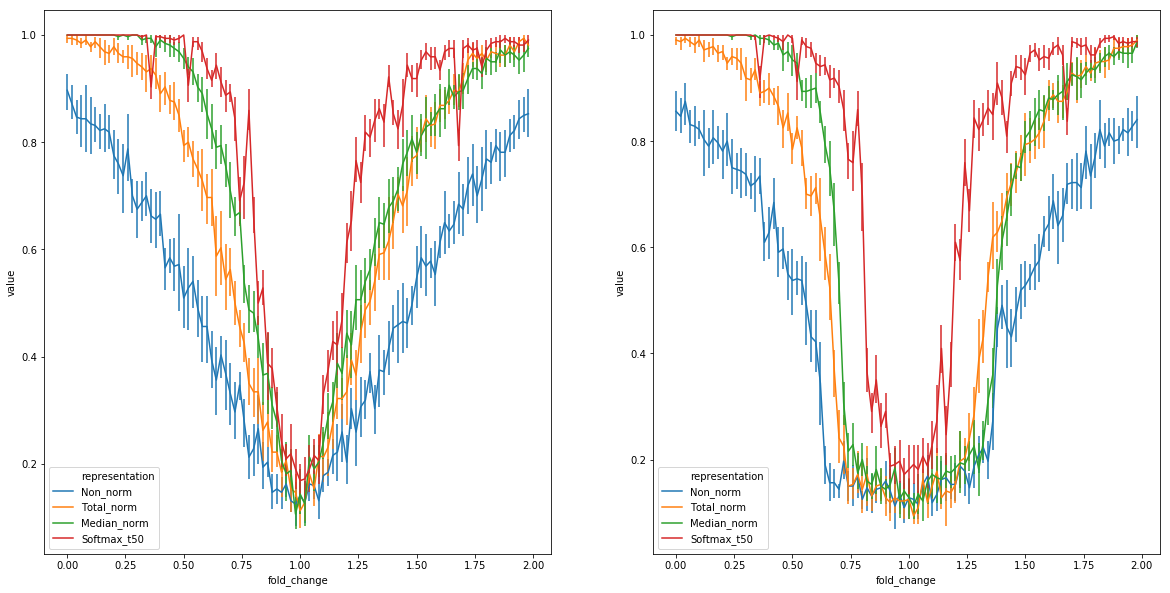

In [365]:

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
pd_df_no = pd_df[(pd_df.metric=='KNN')&(pd_df.projection=='Non_projection')&(pd_df.representation.isin(['Non_norm','Total_norm','Median_norm','Softmax_t50']))]
ax = sns.lineplot(x="fold_change", y="value", data=pd_df_no,err_style='bars',hue='representation')
plt.subplot(1,2,2)
pd_df_PCA = pd_df[(pd_df.metric=='KNN')&(pd_df.projection=='PCA')&(pd_df.representation.isin(['Non_norm','Total_norm','Median_norm','Softmax_t50']))]
ax = sns.lineplot(x="fold_change", y="value", data=pd_df_PCA,err_style='bars',hue='representation')

plt.show()

In [363]:
pd_df_softmax = pd_df[(pd_df.metric=='KNN')&(pd_df.projection=='Non_projection')&(pd_df.representation.isin(['Non_norm','Total_norm','Median_norm','Softmax_t50']))]

In [109]:
# rst_dump_all = pickle.load(open("/home/yzy/SIMS/celline_simu_k2_againstfoldchange.pkl","rb"))
# rst_dump_all = pickle.load(open("/home/yzy/SIMS/celline_simu_k4_0~0.5foldchange_base1.pkl","rb"))
rst_dump_all = pickle.load(open("/home/yzy/SIMS/celline_simu_k4_0.5foldchange_base4.pkl","rb"))



pd_dict = {
    'representation':[],#softmax/mean/mean_total/mean_median
    'clustering':[],
    'fold_change':[],
    'projection':[],
    'metric':[],
    'value':[],
}
# temperature_list = [10,20,30,40,50,60,70,80,90,100]
# temperature_list = range(1,20)

# mean part
for fold_change,representation_dict in rst_dump_all.items():
    for representation,projection_dict in representation_dict.items():
        for projection,clustering_dict in projection_dict.items():
            for clustering,metric_dict in clustering_dict.items():
                for metric,metric_value_list in metric_dict.items():

                    metric_value_list = np.array(metric_value_list).flatten()



                    for metric_value in metric_value_list:
                        pd_dict['clustering'].append(clustering)
                        pd_dict['representation'].append(representation)
                        pd_dict['fold_change'].append(fold_change)
                        pd_dict['projection'].append(projection)
                        pd_dict['metric'].append(metric)
                        pd_dict['value'].append(metric_value)

#         for projection,metric_dict in projection_dict.items():
            
#                 for metric,metric_value_list in metric_dict.items():

#                     metric_value_list = np.array(metric_value_list).flatten()



#                     for metric_value in metric_value_list:
#                         pd_dict['representation'].append(representation)
#                         pd_dict['fold_change'].append(fold_change)
#                         pd_dict['projection'].append(projection)
#                         pd_dict['metric'].append(metric)
#                         pd_dict['value'].append(metric_value)


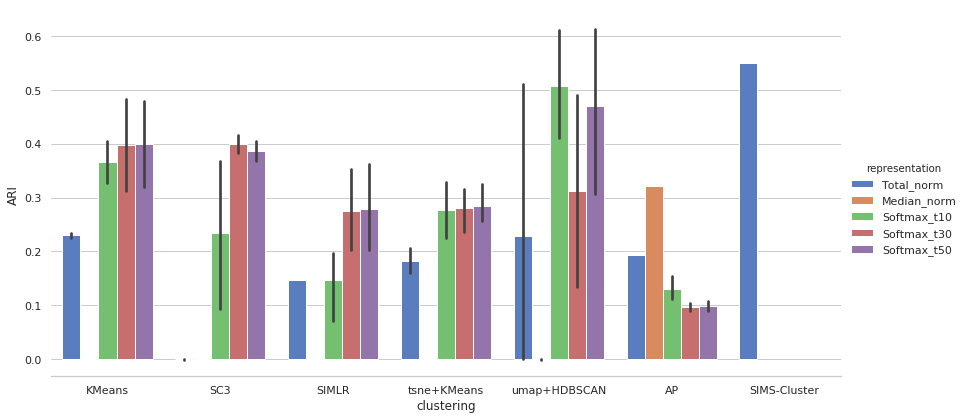

In [114]:
sns.set(style="whitegrid")
pd_df_selected = pd.DataFrame(pd_dict)

pd_df_selected = pd_df_selected[(a.fold_change==0.5)]
pd_df_selected.loc[len(pd_df_selected)] = ['SIMS-Cluster',0.4,'ARI','Non_projection','Total_norm',0.55]
pd_df_selected = pd_df_selected[pd_df_selected.metric=='ARI']
pd_df_selected = pd_df_selected.loc[pd_df_selected.clustering!='Spectral']
pd_df_selected.loc[(pd_df_selected.representation=='Median_norm'),'value']/=3

g = sns.catplot(x="clustering", y="value", hue="representation", data=pd_df_selected,
                height=6, aspect=2,kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("ARI")
plt.show()

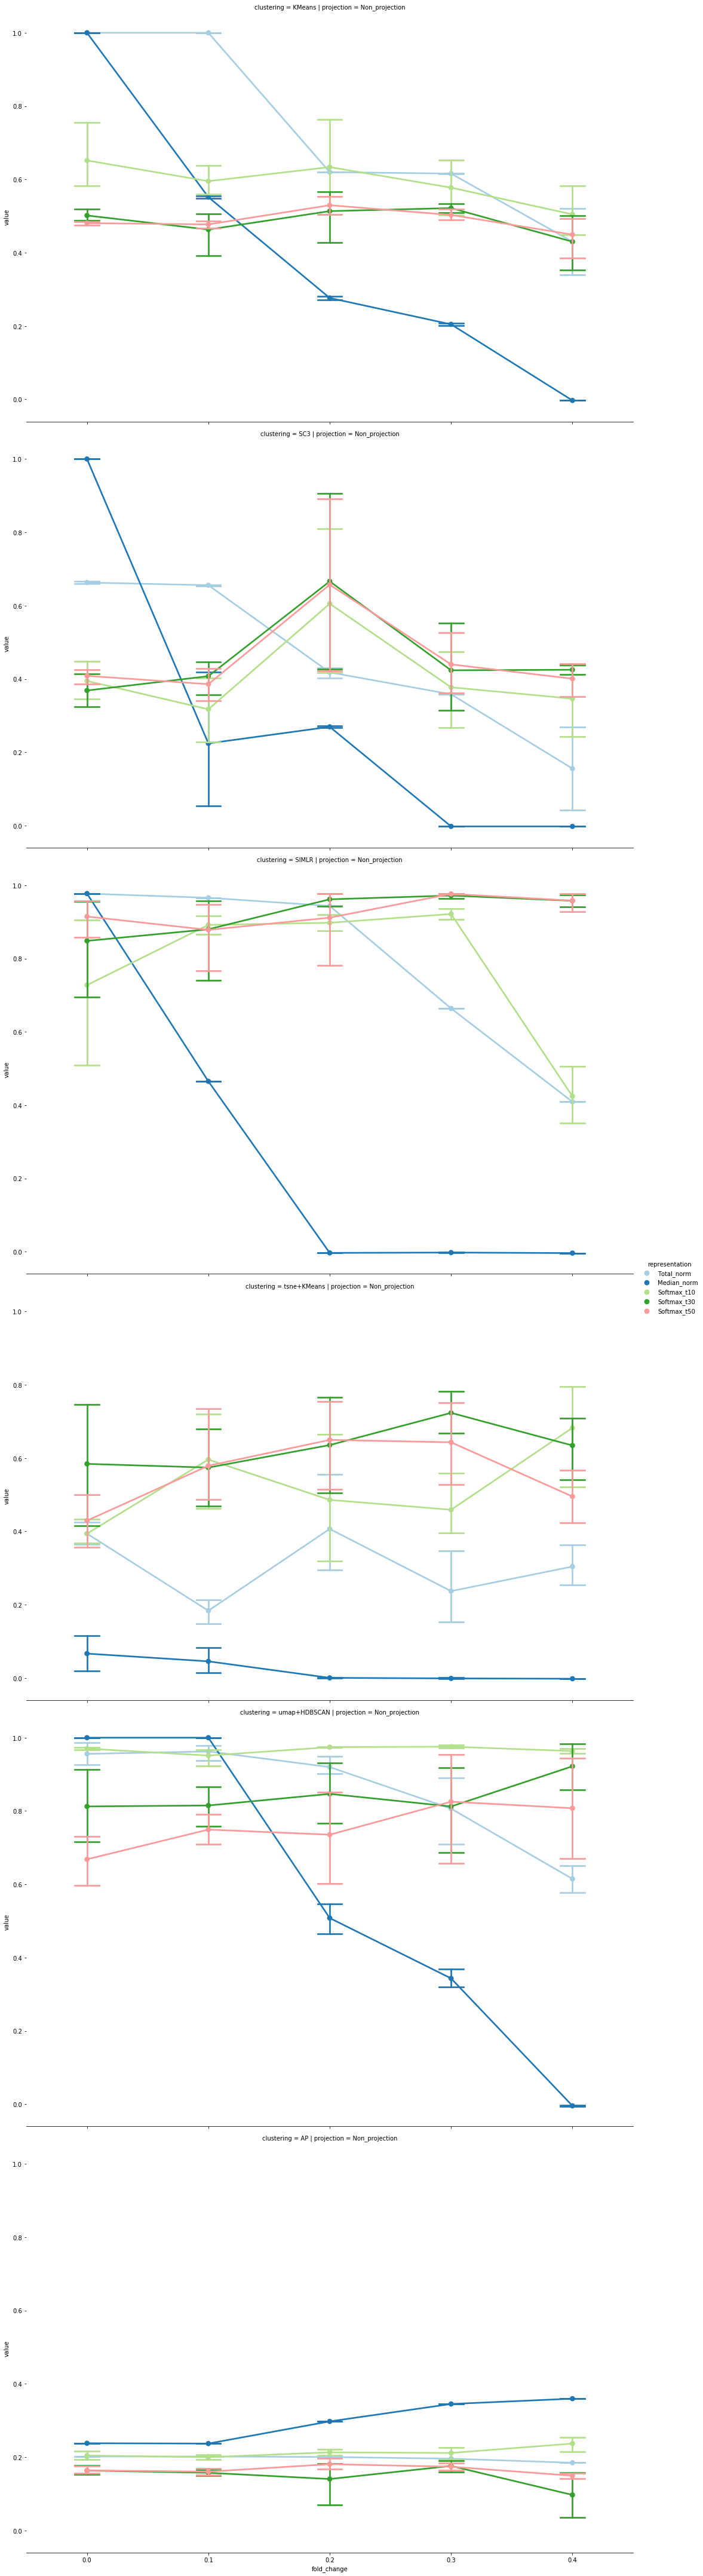

In [12]:
pd_df = pd.DataFrame(pd_dict)
pd_df=pd_df[pd_df.metric=='ARI']

g = sns.catplot(x="fold_change", y="value", hue="representation", col="projection",row="clustering",
                capsize=.2, palette="Paired", height=10, aspect=1.5,
                kind="point", data=pd_df)
g.despine(left=True)
plt.show()


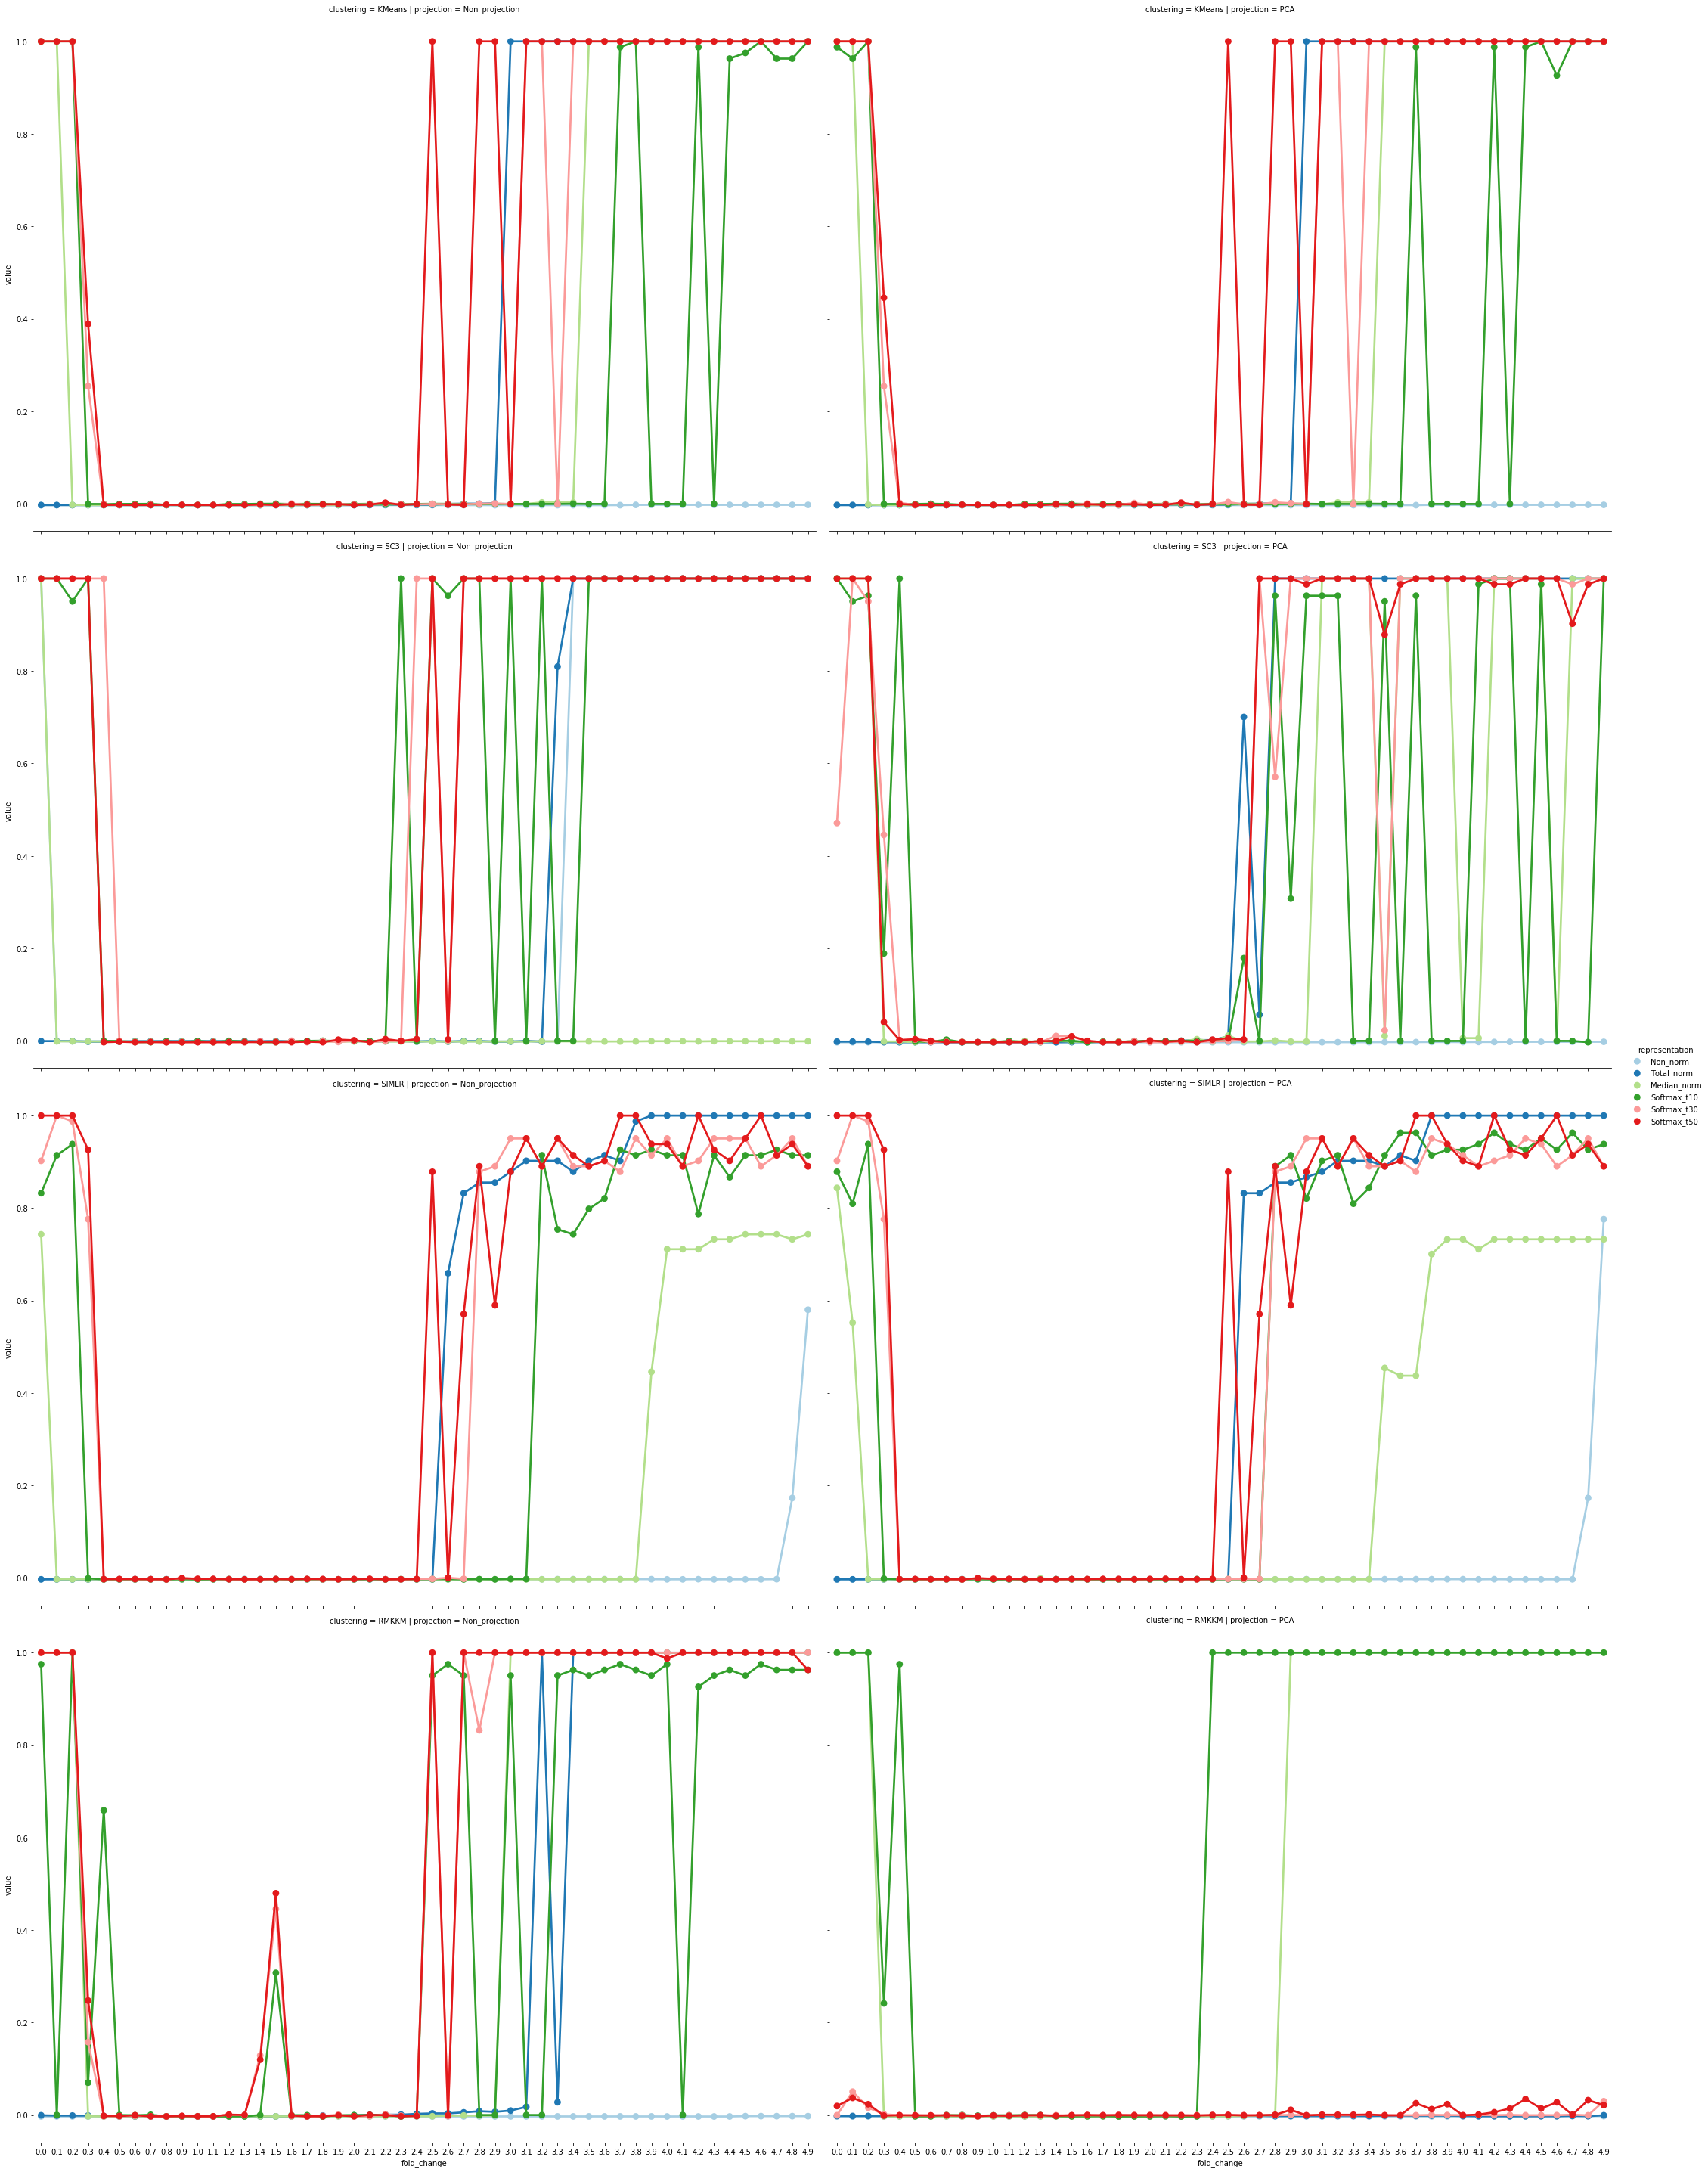

In [19]:
plt.show()

In [366]:
rst_dump_svm = pickle.load(open("/home/yzy/SIMS/celline_simu_k2_againstfoldchange_svm.pkl","rb"))

pd_dict = {
    'representation':[],#softmax/mean/mean_total/mean_median
    'fold_change':[],
    'projection':[],
    'metric':[],
    'value':[],
}
# temperature_list = [10,20,30,40,50,60,70,80,90,100]
# temperature_list = range(1,20)

# add mean
for fold_change,representation_dict in rst_dump_svm.items():
    for representation,projection_dict in representation_dict.items():
        for projection,metric_dict in projection_dict.items():
            
                for metric,metric_value_list in metric_dict.items():

                    metric_value_list = np.array(metric_value_list).flatten()



                    for metric_value in metric_value_list:
                        pd_dict['representation'].append(representation)
                        pd_dict['fold_change'].append(fold_change)
                        pd_dict['projection'].append(projection)
                        pd_dict['metric'].append(metric)
                        pd_dict['value'].append(metric_value)


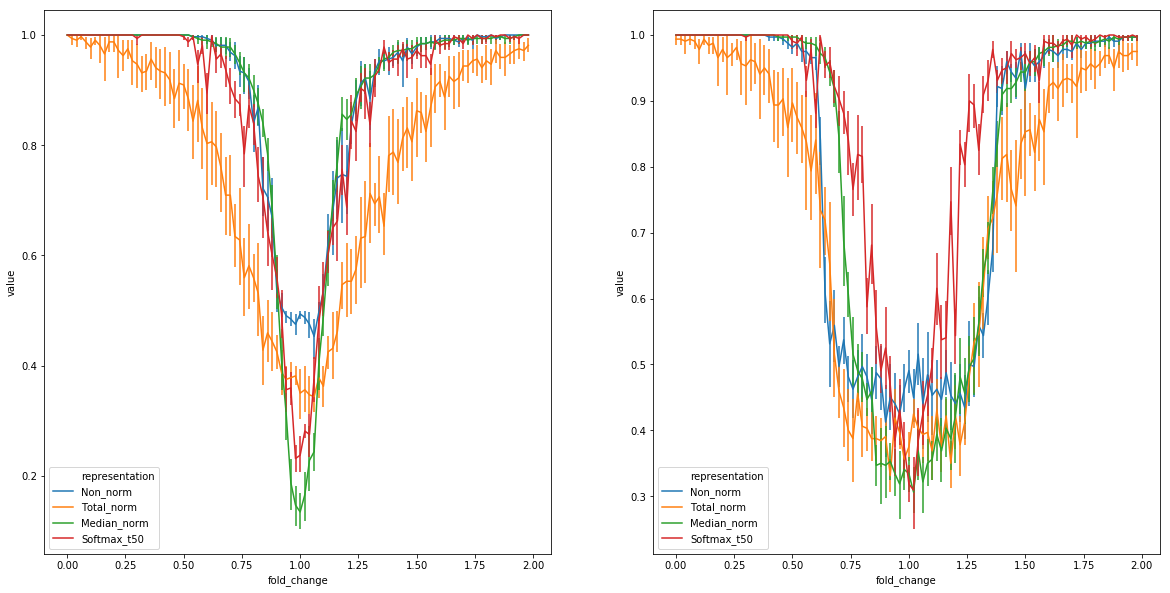

In [367]:
pd_df = pd.DataFrame(pd_dict)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
pd_df_no = pd_df[(pd_df.metric=='KNN')&(pd_df.projection=='Non_projection')&(pd_df.representation.isin(['Non_norm','Total_norm','Median_norm','Softmax_t50']))]
ax = sns.lineplot(x="fold_change", y="value", data=pd_df_no,err_style='bars',hue='representation')
plt.subplot(1,2,2)
pd_df_PCA = pd_df[(pd_df.metric=='KNN')&(pd_df.projection=='PCA')&(pd_df.representation.isin(['Non_norm','Total_norm','Median_norm','Softmax_t50']))]
ax = sns.lineplot(x="fold_change", y="value", data=pd_df_PCA,err_style='bars',hue='representation')

plt.show()

In [320]:
pd_df = pd.DataFrame(pd_dict)
pd_df=pd_df[pd_df.metric=='KNN']
# pd_df = pd_df[pd_df.representation.isin(['Softmax_t10','Non_norm','Total_norm','Median_norm'])]
# pd_df = pd_df[pd_df.fold_change>=0 and pd_df.fold_change<=2]
pd_df = pd_df.query('fold_change>=0 & fold_change<=2')
# fig, ax = plt.subplots(figsize=(10,5))
g = sns.catplot(x="fold_change", y="value", hue="representation", col="projection",row="metric",
                capsize=.2, palette="Paired", height=10, aspect=1.5,
                kind="point", data=pd_df)
# g.despine(left=True)
# plt.savefig('test.svg')


t=10 ARI=0.7761869074535749
t=30 ARI=0.5087358151816208
t=50 ARI=0.5028495666259686
t=70 ARI=0.5037507753717874
t=90 ARI=0.5053896161162212


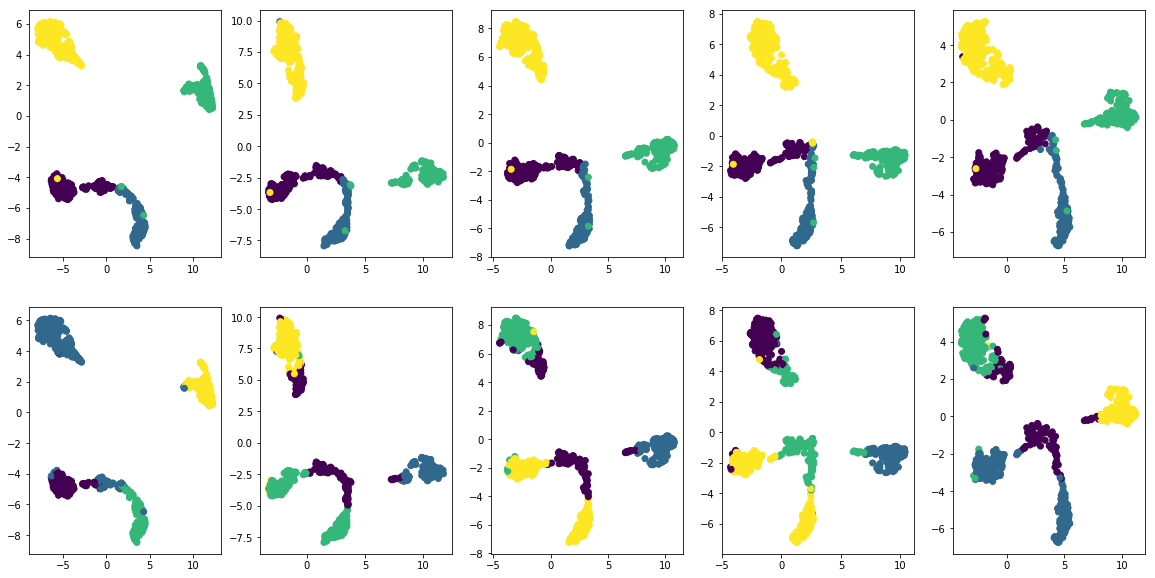

In [12]:
t_list = [10,30,50,70,90]
logit_model = Model(SIMS_input,d4)
pred_logit = logit_model.predict(train_x)
ARI_list = []

i=1
j=len(t_list)+1
plt.figure(figsize=(20,10))
for t in t_list:
    pred_t_softmax = np.exp(pred_logit/t)
    pred_t_softmax = pred_t_softmax/np.sum(pred_t_softmax,axis=1,keepdims=True)
        # softmax_representation_list.append(np.transpose(pred_t_softmax))
    rep = np.transpose(pred_t_softmax)
    cur_corr_mat = squareform(pdist(rep,'correlation'))
    cur_corr_mat = 1/(1+cur_corr_mat)
    cur_label = SpectralClustering(n_clusters=4,affinity='precomputed').fit_predict(cur_corr_mat)
    cur_ARI = metrics.adjusted_rand_score(true_y, cur_label)
    ARI_list.append(cur_ARI)
    print('t={t} ARI={ARI}'.format(t=t,ARI=cur_ARI))
    cur_embed = umap.UMAP(metric='correlation').fit_transform(rep)
    plt.subplot(2,len(t_list),i)
    plt.scatter(cur_embed[:,0],cur_embed[:,1],c=true_y)
    plt.subplot(2,len(t_list),j)
    plt.scatter(cur_embed[:,0],cur_embed[:,1],c=cur_label)


    i+=1
    j+=1
plt.show()

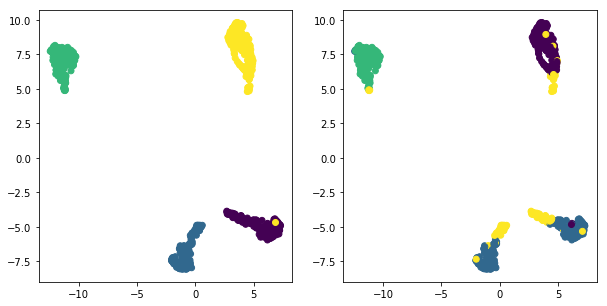

mean ARI=0.6204558855436634


In [23]:
train_x_norm = train_x/np.percentile(train_x,80,axis=1,keepdims=True)
train_x_norm = np.log(train_x_norm+1)
# train_x_norm = StandardScaler().fit_transform(train_x_norm)
mean_profile_list_norm = []
for i in range(num_cells):
    mean_profile_list_norm.append(np.mean(train_x_norm[cell_idx==i+1,:],axis=0))
mean_profile_list_norm = np.array(mean_profile_list_norm)
mean_embed = umap.UMAP(metric='euclidean').fit_transform(mean_profile_list_norm)
mean_label = SpectralClustering(n_clusters=4).fit_predict(mean_profile_list_norm)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(mean_embed[:,0],mean_embed[:,1],c=true_y)
plt.subplot(1,2,2)
plt.scatter(mean_embed[:,0],mean_embed[:,1],c=mean_label)
plt.show()
mean_ARI = metrics.adjusted_rand_score(true_y, mean_label)
print('mean ARI={ARI}'.format(ARI=mean_ARI))



In [7]:
_,unique_idx = np.unique(cell_idx,return_index=True)
true_y = cell_type[unique_idx]
np.unique(true_y)

array([1, 2, 3, 4], dtype=int32)

In [48]:
rst_dump

{'Median_norm': {'Non_projection': {'AMI': [0.62607763642538961,
    0.62510195273209257,
    0.62607763642538961,
    0.62460272871089295,
    0.62460272871089295,
    0.62589408016112968,
    0.62589408016112968,
    0.62607763642538972,
    0.62607763642538961,
    0.62716769178253462],
   'ARI': [0.63305718435097014,
    0.63025376758032881,
    0.63137690789487655,
    0.63137690789487655,
    0.63137690789487655,
    0.62955670188337454,
    0.63137690789487655,
    0.63314542489327008,
    0.6325192084231287,
    0.63137690789487655],
   'KNN': [array([ 1.        ,  0.97222222,  0.98611111,  1.        ,  0.98591549,
            1.        ,  1.        ,  0.98550725,  0.98550725,  1.        ]),
    array([ 0.98611111,  1.        ,  0.98611111,  1.        ,  0.98591549,
            1.        ,  1.        ,  0.98550725,  0.98550725,  0.98550725]),
    array([ 0.97222222,  1.        ,  1.        ,  1.        ,  0.97183099,
            0.98571429,  0.98550725,  1.        ,  1.        

In [ ]:
# mean_total
train_x_total = train_x/np.sum(train_x,axis=1,keepdims=True)
train_x_total = np.log(train_x_total+1)
mean_profile_list_total = []
for i in range(num_cells):
    mean_profile_list_total.append(np.mean(train_x_total[cell_idx==i+1,:],axis=0))
mean_profile_list_total = np.array(mean_profile_list_total)


#mean median
train_x_median = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
train_x_median = np.log(train_x_median+1)
mean_profile_list_median = []
for i in range(num_cells):
    mean_profile_list_median.append(np.mean(train_x_median[cell_idx==i+1,:],axis=0))
mean_profile_list_median = np.array(mean_profile_list_median)



# mean
mean_profile_list = []
for i in range(num_cells):
    mean_profile_list.append(np.mean(train_x[cell_idx==i+1,:],axis=0))
mean_profile_list = np.array(mean_profile_list)


# tsne_param_list = [10,20,30,40,50]
# umap_param_list = [5,10,15,20,25,30]
projection_dim = 10
mean_variant_list = ['Non_norm','Total_norm','Median_norm']
projection_list = ['Non_projection','PCA','TSNE','UMAP']
metrics_list = ['AMI','NMI','ARI','KNN']
rst_dump = {}
run_times = 10

for _ in range(run_times):
    for mean_variant in mean_variant_list:
        cur_representation = None
        if mean_variant == 'Non_norm':
            cur_representation = mean_profile_list
        elif mean_variant == 'Total_norm':
            cur_representation = mean_profile_list_total
        elif mean_variant == 'Median_norm':
            cur_representation = mean_profile_list_median
        if mean_variant not in rst_dump:
            rst_dump[mean_variant] = {}
        for projection in projection_list:
            cur_embed = None
            if projection=='Non_projection':
                cur_embed = cur_representation
            elif projection=='PCA':
                cur_embed = PCA(n_components=projection_dim).fit_transform(cur_representation)
            elif projection=='TSNE':
                cur_embed = TSNE(n_components=projection_dim,metric='euclidean',verbose=False,method='exact').fit_transform(cur_representation)
            elif projection=='UMAP':
                cur_embed = umap.UMAP(n_components=projection_dim,metric='euclidean',verbose=False).fit_transform(cur_representation)
            if projection not in rst_dump[mean_variant]:
                rst_dump[mean_variant][projection] = {}
            for metric in metrics_list:
                cur_rst = None
                cur_label = KMeans(n_clusters=4).fit_predict(cur_embed)
                if metric=='AMI':
                    cur_rst = metrics.adjusted_mutual_info_score(true_y,cur_label)
                elif metric=='NMI':
                    cur_rst = metrics.normalized_mutual_info_score(true_y,cur_label)
                elif metric=='ARI':
                    cur_rst = metrics.adjusted_rand_score(true_y,cur_label)
                elif metric=='KNN':
                    kf = StratifiedKFold(n_splits=10,shuffle=True)
                    knn = KNeighborsClassifier(metric='euclidean')
                    cur_rst=cross_val_score(knn, cur_embed, true_y, scoring='accuracy',cv=kf,verbose=0)
                if metric not in rst_dump[mean_variant][projection]:
                    rst_dump[mean_variant][projection][metric] = [cur_rst]
                else:
                    rst_dump[mean_variant][projection][metric].append(cur_rst)
                print(str(_),mean_variant,projection,metric,'|',cur_rst)



pickle.dump(rst_dump,open("/home/yzy/SIMS/mean_rst_dump_4cellline_1031.pkl","wb"))


            

        




0 Non_norm Non_projection AMI | 0.282140319253
0 Non_norm Non_projection NMI | 0.291146973397
0 Non_norm Non_projection ARI | 0.190352081834
0 Non_norm Non_projection KNN | [ 0.91666667  0.95833333  1.          0.94444444  0.92957746  0.98571429
  0.98550725  0.89855072  0.95652174  0.94202899]
0 Non_norm PCA AMI | 0.282140319253
0 Non_norm PCA NMI | 0.291146973397
0 Non_norm PCA ARI | 0.187698181498
0 Non_norm PCA KNN | [ 0.97222222  0.95833333  0.91666667  0.91666667  0.94366197  0.94285714
  0.98550725  0.97101449  0.97101449  0.98550725]
0 Non_norm TSNE AMI | 0.280559457511
0 Non_norm TSNE NMI | 0.315608017575
0 Non_norm TSNE ARI | 0.306577872644
0 Non_norm TSNE KNN | [ 0.93055556  0.94444444  0.97222222  0.91666667  0.92957746  0.91428571
  0.95652174  0.94202899  0.92753623  1.        ]
0 Non_norm UMAP AMI | 0.406015278459
0 Non_norm UMAP NMI | 0.409272283814
0 Non_norm UMAP ARI | 0.29484022732
0 Non_norm UMAP KNN | [ 0.93055556  0.90277778  0.93055556  0.90277778  0.90140845  0.

In [106]:
# pixel_total
train_x_total = train_x/np.sum(train_x,axis=1,keepdims=True)
train_x_total = np.log(train_x_total+1)

# pixel median
train_x_median = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
train_x_median = np.log(train_x_median+1)


# mean


# tsne_param_list = [10,20,30,40,50]
# umap_param_list = [5,10,15,20,25,30]
projection_dim = 10
mean_variant_list = ['Non_norm','Total_norm','Median_norm']
projection_list = ['Non_projection','PCA','TSNE','UMAP']
metrics_list = ['AMI','NMI','ARI','KNN']
rst_dump = {}
run_times = 10

for _ in range(run_times):
    for mean_variant in mean_variant_list:
        cur_representation = None
        if mean_variant == 'Non_norm':
            cur_representation = train_x
        elif mean_variant == 'Total_norm':
            cur_representation = train_x_total
        elif mean_variant == 'Median_norm':
            cur_representation = train_x_median
        if mean_variant not in rst_dump:
            rst_dump[mean_variant] = {}
        for projection in projection_list:
            cur_embed = None
            if projection=='Non_projection':
                cur_embed = cur_representation
            elif projection=='PCA':
                cur_embed = PCA(n_components=projection_dim).fit_transform(cur_representation)
            elif projection=='TSNE':
#                 cur_embed = TSNE(n_components=projection_dim,metric='euclidean',verbose=True,method='exact').fit_transform(cur_representation)
                cur_embed = cur_representation
            elif projection=='UMAP':
                cur_embed = umap.UMAP(n_components=projection_dim,metric='euclidean',verbose=True).fit_transform(cur_representation)
            if projection not in rst_dump[mean_variant]:
                rst_dump[mean_variant][projection] = {}
            for metric in metrics_list:
                cur_rst = None
#                 cur_label = KMeans(n_clusters=4).fit_predict(cur_embed)
                cur_label = majorvote_clustering(cur_embed,cell_idx,4,norm=True)
                if metric=='AMI':
                    cur_rst = metrics.adjusted_mutual_info_score(true_y,cur_label)
                elif metric=='NMI':
                    cur_rst = metrics.normalized_mutual_info_score(true_y,cur_label)
                elif metric=='ARI':
                    cur_rst = metrics.adjusted_rand_score(true_y,cur_label)
                elif metric=='KNN':
                    cur_rst = 0
#                     kf = StratifiedKFold(n_splits=10,shuffle=True)
#                     knn = KNeighborsClassifier(metric='euclidean')
#                     cur_rst=cross_val_score(knn, cur_embed, true_y, scoring='accuracy',cv=kf,verbose=0)
                if metric not in rst_dump[mean_variant][projection]:
                    rst_dump[mean_variant][projection][metric] = [cur_rst]
                else:
                    rst_dump[mean_variant][projection][metric].append(cur_rst)
                print(str(_),mean_variant,projection,metric,'|',cur_rst)



pickle.dump(rst_dump,open("/home/yzy/SIMS/vote_norm_rst_dump_4cellline_1031.pkl","wb"))


            

        





0 Non_norm Non_projection AMI | 0.276036412688
0 Non_norm Non_projection NMI | 0.28854593985
0 Non_norm Non_projection ARI | 0.193282679097
0 Non_norm Non_projection KNN | 0
0 Non_norm PCA AMI | 0.275055304879
0 Non_norm PCA NMI | 0.290929955173
0 Non_norm PCA ARI | 0.190083789398
0 Non_norm PCA KNN | 0
0 Non_norm TSNE AMI | 0.276036412688
0 Non_norm TSNE NMI | 0.289456883547
0 Non_norm TSNE ARI | 0.193282679097
0 Non_norm TSNE KNN | 0
UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.1, n_components=10, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  14
	 1  /  14
	 2  /  14
	 3  /  14
	 

In [119]:
# for i in range(n_softmax):
#     reset_weights(softmax_model)
    
#     history=softmax_model.fit([train_x,cell_idx-1],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=200,shuffle=True,batch_size=64)
softmax_representation_list = []
t_list = range(5,15)
for pred_logit in logit_list:  
    for t in t_list:
        print(i)
    #     history=softmax_model.fit([train_x,cur_label],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=50,shuffle=True,batch_size=64,verbose=True)

#         pred_logit = logit_model.predict(train_x)
        pred_t_softmax = np.exp(pred_logit/t)
        pred_t_softmax = pred_t_softmax/np.sum(pred_t_softmax,axis=1,keepdims=True)
        softmax_representation_list.append(np.transpose(pred_t_softmax))




9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9


In [126]:
sio.savemat('cellline_member_mat_original_t5~t20',{'member_mat_original':member_mat_original})
sio.savemat('cellline_member_mat_embed_t5~t20',{'member_mat_embed':member_mat_embed})

In [125]:
sio.savemat('cellline_true_y',{'cellline_true_y':true_y})

In [ ]:
tsne_param_list = [10,20,30,40,50]
umap_param_list = [5,10,15,20,25,30]
projection_dim = 10
# mean_variant_list = ['Non_norm','Total_norm','Median_norm']
# temperature_list = [10,20,30,40,50,60,70,80,90,100]
temperature_list = range(1,20)
train_epoch = 200
train_batch_size = 64
projection_list = ['Non_projection','PCA','TSNE','UMAP']
metrics_list = ['AMI','NMI','ARI','KNN']
rst_dump = {}
logit_list = pickle.load(open("/home/yzy/SIMS/softmax_logit_dump_4cellline_1031_new.pkl","rb"))
# logit_list = logit_list[1:]
run_times = 10

   



# for _ in range(run_times):
#     reset_weights(softmax_model)
#     history=softmax_model.fit([train_x,cell_idx-1],[onehot_label,np.ones(shape=cell_idx.shape)],epochs=200,shuffle=True,batch_size=64)
#     logit_model = Model(SIMS_input,d4)
#     pred_logit = logit_model.predict(train_x)
#     logit_list.append(pred_logit)
_=0
for pred_logit in logit_list:
    _+=1
    for temperature in temperature_list:
        pred_t_softmax = np.exp(pred_logit/temperature)
        pred_t_softmax = pred_t_softmax/np.sum(pred_t_softmax,axis=1,keepdims=True)
        pred_t_softmax[np.isnan(pred_t_softmax)]=1
        cur_representation = np.transpose(pred_t_softmax)
        if temperature not in rst_dump:
            rst_dump[temperature] = {}
        
        
        for projection in projection_list:
            cur_embed = None
            if projection=='Non_projection':
                cur_embed = cur_representation
            elif projection=='PCA':
                cur_embed = PCA(n_components=projection_dim).fit_transform(cur_representation)
            elif projection=='TSNE':
                cur_embed = TSNE(n_components=projection_dim,metric='correlation',verbose=False,method='exact').fit_transform(cur_representation)
            elif projection=='UMAP':
                cur_embed = umap.UMAP(n_components=projection_dim,metric='correlation',verbose=False).fit_transform(cur_representation)
            if projection not in rst_dump[temperature]:
                rst_dump[temperature][projection] = {}
            for metric in metrics_list:
                cur_rst = None
                if projection in ['Non_projection','PCA']:
                    corr_mat = squareform(pdist(cur_embed,'correlation'))
                    corr_mat = 1/(1+corr_mat)
                    cur_label = SpectralClustering(n_clusters=4,affinity='precomputed').fit_predict(corr_mat)
                else:
                    cur_label = KMeans(n_clusters=4).fit_predict(cur_embed)
                if metric=='AMI':
                    cur_rst = metrics.adjusted_mutual_info_score(true_y,cur_label)
                elif metric=='NMI':
                    cur_rst = metrics.normalized_mutual_info_score(true_y,cur_label)
                elif metric=='ARI':
                    cur_rst = metrics.adjusted_rand_score(true_y,cur_label)
                elif metric=='KNN':
                    kf = StratifiedKFold(n_splits=10,shuffle=True)
                    knn = KNeighborsClassifier(metric='correlation')
                    cur_rst=cross_val_score(knn, cur_embed, true_y, scoring='accuracy',cv=kf,verbose=0)
                if metric not in rst_dump[temperature][projection]:
                    rst_dump[temperature][projection][metric] = [cur_rst]
                else:
                    rst_dump[temperature][projection][metric].append(cur_rst)
                print(str(_),temperature,projection,metric,'|',cur_rst)



pickle.dump(rst_dump,open("/home/yzy/SIMS/softmax_rst_dump_4cellline_1031_t1~t20.pkl","wb"))
# pickle.dump(logit_list,open("/home/yzy/SIMS/softmax_logit_dump_4cellline_1031_new.pkl","wb"))



/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


1 1 Non_projection AMI | 0.0573872417089
1 1 Non_projection NMI | 0.117731850939
1 1 Non_projection ARI | -0.00572669241304
1 1 Non_projection KNN | [ 0.65277778  0.65277778  0.66666667  0.69444444  0.81690141  0.74285714
  0.72463768  0.79710145  0.73913043  0.71014493]
1 1 PCA AMI | 0.0730298654925
1 1 PCA NMI | 0.105110013908
1 1 PCA ARI | 0.00100071271751
1 1 PCA KNN | [ 0.77777778  0.66666667  0.81944444  0.80555556  0.71830986  0.7
  0.73913043  0.76811594  0.7826087   0.69565217]
1 1 TSNE AMI | 0.00278156082777
1 1 TSNE NMI | 0.0097581073347
1 1 TSNE ARI | 0.00762747590973
1 1 TSNE KNN | [ 0.29166667  0.33333333  0.38888889  0.29166667  0.29577465  0.3
  0.33333333  0.39130435  0.33333333  0.34782609]
1 1 UMAP AMI | 0.054984740627
1 1 UMAP NMI | 0.0650483086885
1 1 UMAP ARI | 0.0232394580499
1 1 UMAP KNN | [ 0.88888889  0.875       0.84722222  0.91666667  0.85915493  0.85714286
  0.85507246  0.89855072  0.89855072  0.89855072]
1 2 Non_projection AMI | 0.438300833668
1 2 Non_proj

/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


2 1 Non_projection AMI | 0.0500782781724
2 1 Non_projection NMI | 0.097896514812
2 1 Non_projection ARI | -0.00650120520445
2 1 Non_projection KNN | [ 0.73611111  0.75        0.66666667  0.72222222  0.73239437  0.78571429
  0.66666667  0.60869565  0.7826087   0.73913043]
2 1 PCA AMI | 0.0779460559244
2 1 PCA NMI | 0.110500539676
2 1 PCA ARI | 0.0011995656303
2 1 PCA KNN | [ 0.75        0.76388889  0.68055556  0.76388889  0.70422535  0.7
  0.69565217  0.65217391  0.5942029   0.69565217]
2 1 TSNE AMI | 0.00562958863254
2 1 TSNE NMI | 0.00934866099486
2 1 TSNE ARI | 0.00319429253797
2 1 TSNE KNN | [ 0.375       0.43055556  0.31944444  0.33333333  0.30985915  0.24285714
  0.23188406  0.23188406  0.31884058  0.23188406]
2 1 UMAP AMI | 0.0952708841561
2 1 UMAP NMI | 0.10847933784
2 1 UMAP ARI | 0.0367271276336
2 1 UMAP KNN | [ 0.88888889  0.88888889  0.83333333  0.79166667  0.84507042  0.91428571
  0.85507246  0.8115942   0.85507246  0.88405797]


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


2 2 Non_projection AMI | 0.464585130668
2 2 Non_projection NMI | 0.523803224211
2 2 Non_projection ARI | 0.336392879624
2 2 Non_projection KNN | [ 0.98611111  0.98611111  1.          1.          1.          1.          1.
  1.          0.97101449  1.        ]
2 2 PCA AMI | 0.353694976773
2 2 PCA NMI | 0.401892222709
2 2 PCA ARI | 0.324936167721
2 2 PCA KNN | [ 0.79166667  0.81944444  0.88888889  0.77777778  0.85915493  0.9
  0.79710145  0.86956522  0.7826087   0.85507246]
2 2 TSNE AMI | -0.0011763826841
2 2 TSNE NMI | 0.0188483462701
2 2 TSNE ARI | -0.000243118727492
2 2 TSNE KNN | [ 0.29166667  0.38888889  0.40277778  0.45833333  0.46478873  0.41428571
  0.42028986  0.37681159  0.42028986  0.4057971 ]
2 2 UMAP AMI | 0.976425342931
2 2 UMAP NMI | 0.977302136362
2 2 UMAP ARI | 0.983385394055
2 2 UMAP KNN | [ 1.          1.          1.          1.          0.98591549  0.98571429
  0.98550725  1.          0.98550725  1.        ]
2 3 Non_projection AMI | 0.577595698613
2 3 Non_projection N

/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


5 1 Non_projection AMI | 0.0509806209837
5 1 Non_projection NMI | 0.106994976788
5 1 Non_projection ARI | -0.0072519259845
5 1 Non_projection KNN | [ 0.625       0.66666667  0.77777778  0.59722222  0.71830986  0.7
  0.75362319  0.7826087   0.69565217  0.69565217]
5 1 PCA AMI | 0.0837539137191
5 1 PCA NMI | 0.118253451911
5 1 PCA ARI | 0.00474107300841
5 1 PCA KNN | [ 0.68055556  0.76388889  0.70833333  0.65277778  0.69014085  0.67142857
  0.68115942  0.71014493  0.69565217  0.69565217]
5 1 TSNE AMI | 0.010620664638
5 1 TSNE NMI | 0.0221413910067
5 1 TSNE ARI | 0.014214486426
5 1 TSNE KNN | [ 0.29166667  0.29166667  0.375       0.34722222  0.28169014  0.27142857
  0.33333333  0.30434783  0.1884058   0.37681159]
5 1 UMAP AMI | 0.0811662764414
5 1 UMAP NMI | 0.0925425538972
5 1 UMAP ARI | 0.0379408341861
5 1 UMAP KNN | [ 0.81944444  0.81944444  0.76388889  0.81944444  0.90140845  0.84285714
  0.89855072  0.86956522  0.85507246  0.88405797]


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


5 2 Non_projection AMI | 0.477099820748
5 2 Non_projection NMI | 0.535165587058
5 2 Non_projection ARI | 0.352000595274
5 2 Non_projection KNN | [ 1.          1.          1.          1.          1.          1.          1.
  0.95652174  1.          1.        ]
5 2 PCA AMI | 0.383326005611
5 2 PCA NMI | 0.422427397317
5 2 PCA ARI | 0.378595327875
5 2 PCA KNN | [ 0.72222222  0.80555556  0.79166667  0.84722222  0.81690141  0.81428571
  0.8115942   0.82608696  0.75362319  0.82608696]
5 2 TSNE AMI | -0.000884334834724
5 2 TSNE NMI | 0.0215824457042
5 2 TSNE ARI | -0.00157565988244
5 2 TSNE KNN | [ 0.38888889  0.375       0.375       0.31944444  0.28169014  0.42857143
  0.37681159  0.33333333  0.39130435  0.34782609]
5 2 UMAP AMI | 0.973906681124
5 2 UMAP NMI | 0.974143664734
5 2 UMAP ARI | 0.984254795927
5 2 UMAP KNN | [ 0.98611111  0.98611111  0.98611111  0.98611111  1.          1.          1.
  1.          1.          1.        ]
5 3 Non_projection AMI | 0.560962948834
5 3 Non_projection N

/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


7 1 Non_projection AMI | 0.0507289881157
7 1 Non_projection NMI | 0.102344115689
7 1 Non_projection ARI | -0.0068325081495
7 1 Non_projection KNN | [ 0.75        0.76388889  0.81944444  0.76388889  0.76056338  0.6
  0.79710145  0.7826087   0.75362319  0.72463768]
7 1 PCA AMI | 0.0647272868705
7 1 PCA NMI | 0.0978107519217
7 1 PCA ARI | -0.00209299550451
7 1 PCA KNN | [ 0.72222222  0.65277778  0.625       0.68055556  0.71830986  0.67142857
  0.71014493  0.82608696  0.71014493  0.71014493]
7 1 TSNE AMI | 0.00439937475398
7 1 TSNE NMI | 0.0108307942337
7 1 TSNE ARI | -8.44008444473e-05
7 1 TSNE KNN | [ 0.36111111  0.36111111  0.31944444  0.29166667  0.25352113  0.28571429
  0.39130435  0.4057971   0.33333333  0.26086957]
7 1 UMAP AMI | 0.079390315949
7 1 UMAP NMI | 0.0944946353838
7 1 UMAP ARI | 0.0434629294108
7 1 UMAP KNN | [ 0.875       0.81944444  0.83333333  0.84722222  0.85915493  0.84285714
  0.88405797  0.88405797  0.92753623  0.85507246]


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


7 2 Non_projection AMI | 0.442308750896
7 2 Non_projection NMI | 0.506082789804
7 2 Non_projection ARI | 0.310363734995
7 2 Non_projection KNN | [ 1.          1.          0.97222222  1.          1.          1.
  0.98550725  1.          1.          0.97101449]
7 2 PCA AMI | 0.243329383796
7 2 PCA NMI | 0.293745987945
7 2 PCA ARI | 0.222448484699
7 2 PCA KNN | [ 0.88888889  0.86111111  0.88888889  0.86111111  0.8028169   0.9
  0.79710145  0.84057971  0.8115942   0.85507246]
7 2 TSNE AMI | -0.000185967970063
7 2 TSNE NMI | 0.0226060422647
7 2 TSNE ARI | -0.00239309928902
7 2 TSNE KNN | [ 0.34722222  0.375       0.38888889  0.40277778  0.47887324  0.38571429
  0.39130435  0.4057971   0.42028986  0.42028986]
7 2 UMAP AMI | 0.973906681124
7 2 UMAP NMI | 0.974143664734
7 2 UMAP ARI | 0.984254795927
7 2 UMAP KNN | [ 1.          0.98611111  1.          0.98611111  0.98591549  0.98571429
  1.          1.          1.          1.        ]
7 3 Non_projection AMI | 0.556185666126
7 3 Non_projection 

/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


8 1 Non_projection AMI | 0.0655911937113
8 1 Non_projection NMI | 0.12518006862
8 1 Non_projection ARI | 0.00785967042713
8 1 Non_projection KNN | [ 0.69444444  0.66666667  0.77777778  0.66666667  0.66197183  0.78571429
  0.68115942  0.69565217  0.7826087   0.63768116]
8 1 PCA AMI | 0.0789808884608
8 1 PCA NMI | 0.112967524366
8 1 PCA ARI | 0.00344093368387
8 1 PCA KNN | [ 0.75        0.75        0.68055556  0.77777778  0.8028169   0.8
  0.82608696  0.8115942   0.72463768  0.79710145]
8 1 TSNE AMI | 0.0137961327231
8 1 TSNE NMI | 0.0317906878266
8 1 TSNE ARI | 0.0131653056562
8 1 TSNE KNN | [ 0.29166667  0.33333333  0.27777778  0.375       0.4084507   0.38571429
  0.31884058  0.2173913   0.27536232  0.34782609]
8 1 UMAP AMI | 0.0722592800517
8 1 UMAP NMI | 0.085075444022
8 1 UMAP ARI | 0.0270579723187
8 1 UMAP KNN | [ 0.875       0.88888889  0.90277778  0.86111111  0.81690141  0.84285714
  0.89855072  0.84057971  0.84057971  0.89855072]
8 2 Non_projection AMI | 0.475413181908
8 2 Non_p

/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


9 1 Non_projection AMI | 0.0504754391046
9 1 Non_projection NMI | 0.0991526748167
9 1 Non_projection ARI | 0.00540928859457
9 1 Non_projection KNN | [ 0.80555556  0.83333333  0.79166667  0.72222222  0.8028169   0.81428571
  0.79710145  0.71014493  0.73913043  0.63768116]
9 1 PCA AMI | 0.0765464201057
9 1 PCA NMI | 0.110633131127
9 1 PCA ARI | 0.000528427795648
9 1 PCA KNN | [ 0.73611111  0.68055556  0.75        0.70833333  0.83098592  0.7
  0.7826087   0.76811594  0.72463768  0.71014493]
9 1 TSNE AMI | 0.0022668510743
9 1 TSNE NMI | 0.0119994083208
9 1 TSNE ARI | 0.00592714449288
9 1 TSNE KNN | [ 0.38888889  0.36111111  0.31944444  0.27777778  0.3943662   0.38571429
  0.31884058  0.23188406  0.33333333  0.37681159]
9 1 UMAP AMI | 0.086157165233
9 1 UMAP NMI | 0.0975261733397
9 1 UMAP ARI | 0.0369991742219
9 1 UMAP KNN | [ 0.77777778  0.90277778  0.84722222  0.86111111  0.90140845  0.87142857
  0.84057971  0.88405797  0.85507246  0.79710145]


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:30: RuntimeWarning: overflow encountered in exp
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


9 2 Non_projection AMI | 0.429034693365
9 2 Non_projection NMI | 0.49584001074
9 2 Non_projection ARI | 0.293498395387
9 2 Non_projection KNN | [ 1.          1.          0.98611111  1.          1.          0.98571429
  1.          0.97101449  1.          1.        ]
9 2 PCA AMI | 0.383890097679
9 2 PCA NMI | 0.429788777243
9 2 PCA ARI | 0.363767048374
9 2 PCA KNN | [ 0.91666667  0.875       0.88888889  0.84722222  0.84507042  0.84285714
  0.91304348  0.84057971  0.84057971  0.85507246]
9 2 TSNE AMI | -8.41871911161e-06
9 2 TSNE NMI | 0.0186638264333
9 2 TSNE ARI | -0.000431077943541
9 2 TSNE KNN | [ 0.52777778  0.5         0.47222222  0.43055556  0.42253521  0.44285714
  0.52173913  0.33333333  0.4057971   0.56521739]
9 2 UMAP AMI | 0.980479576842
9 2 UMAP NMI | 0.980658319813
9 2 UMAP ARI | 0.988364566236
9 2 UMAP KNN | [ 1.          1.          1.          0.98611111  1.          1.          1.
  0.98550725  0.98550725  1.        ]
9 3 Non_projection AMI | 0.532046533935
9 3 Non_proj

In [98]:
pred_t_softmax = np.exp(pred_logit/temperature)
pred_t_softmax = pred_t_softmax/np.sum(pred_t_softmax,axis=1,keepdims=True)
pred_t_softmax[np.isnan(pred_t_softmax)]=1


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [103]:
rst_dump

{1: {'Non_projection': {'AMI': [0.057387241708868705, 0.050078278172441107],
   'ARI': [-0.0057266924130398586],
   'KNN': [array([ 0.69444444,  0.65277778,  0.72222222,  0.68055556,  0.78873239,
            0.78571429,  0.69565217,  0.75362319,  0.63768116,  0.75362319])],
   'NMI': [0.11630472299919872]},
  'PCA': {'AMI': [0.075543726486043031],
   'ARI': [0.0015268911968565363],
   'KNN': [array([ 0.80555556,  0.75      ,  0.66666667,  0.68055556,  0.73239437,
            0.72857143,  0.69565217,  0.75362319,  0.68115942,  0.75362319])],
   'NMI': [0.10844198156292775]},
  'TSNE': {'AMI': [0.0098079931503485575],
   'ARI': [0.01053241685302979],
   'KNN': [array([ 0.40277778,  0.40277778,  0.375     ,  0.38888889,  0.25352113,
            0.32857143,  0.42028986,  0.34782609,  0.27536232,  0.31884058])],
   'NMI': [0.014032242359359827]},
  'UMAP': {'AMI': [0.059479041716020101],
   'ARI': [0.027640447331910498],
   'KNN': [array([ 0.95833333,  0.875     ,  0.86111111,  0.86111111, 

In [58]:
pickle.dump(logit_list,open("/home/yzy/SIMS/softmax_logit_dump_4cellline_1031.pkl","wb"))



In [192]:
data_dump = pickle.load(open('cellline_randmul_data_randmul2_1026.pkl','rb'))

In [193]:
data_dump

{1: {'mean': array([[ 0.03846154,  3.38461538,  4.19230769, ...,  0.11538462,
           0.26923077,  0.11538462],
         [ 0.        ,  3.        ,  3.7       , ...,  0.1       ,
           0.6       ,  0.1       ],
         [ 0.05555556,  2.77777778,  3.27777778, ...,  0.11111111,
           0.5       ,  0.05555556],
         ..., 
         [ 0.        ,  0.95736965,  2.66282669, ...,  0.16979795,
           0.41419826,  0.1158388 ],
         [ 0.        ,  2.63189076,  3.40675481, ...,  0.26370297,
           0.28193718,  0.09730111],
         [ 0.        ,  1.27158212,  1.91894755, ...,  0.        ,
           0.39638307,  0.        ]]),
  'rep': [array([[ 0.00105733,  0.00102798,  0.00110629, ...,  0.00087035,
            0.00073142,  0.00074537],
          [ 0.00077317,  0.00069642,  0.00068913, ...,  0.00068693,
            0.00072539,  0.00069856],
          [ 0.00085648,  0.00072827,  0.00075669, ...,  0.00072713,
            0.00066604,  0.00072664],
          ..., 
       

1 0


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


1 1
1 2
1 3
1 4


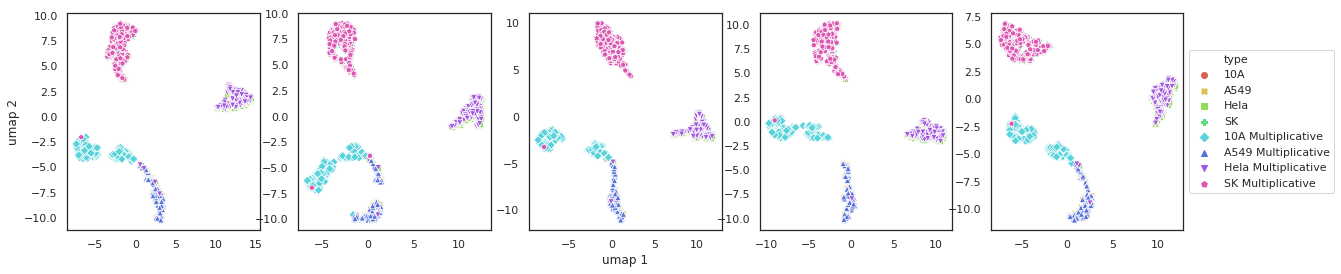

2 0
2 1
2 2
2 3
2 4


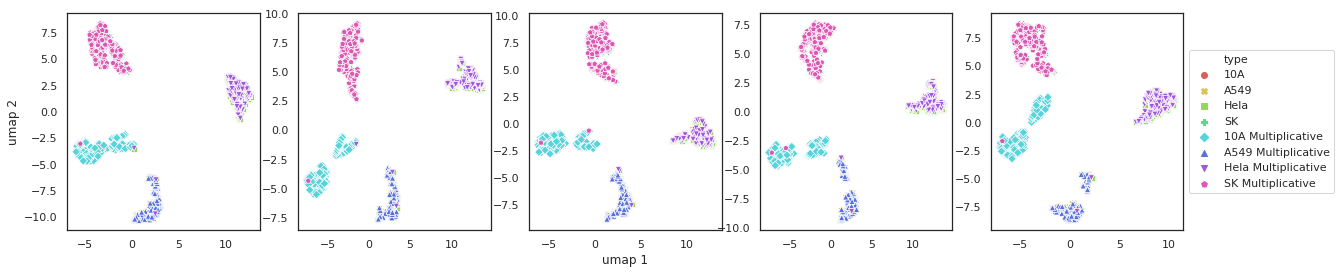

3 0
3 1
3 2
3 3
3 4


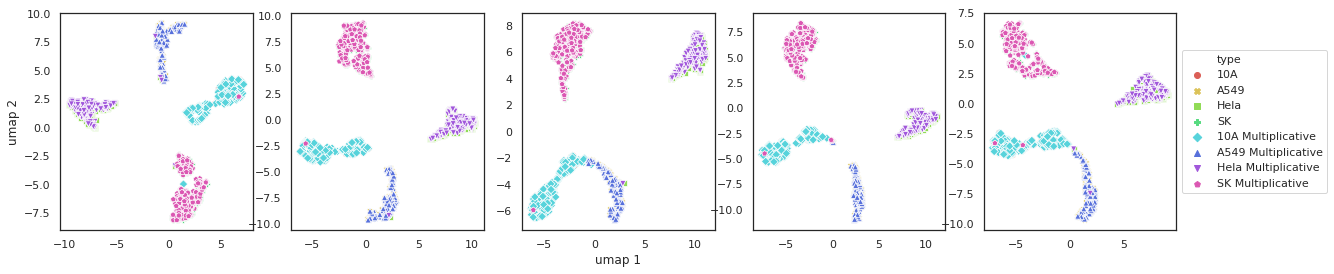

4 0
4 1
4 2
4 3
4 4


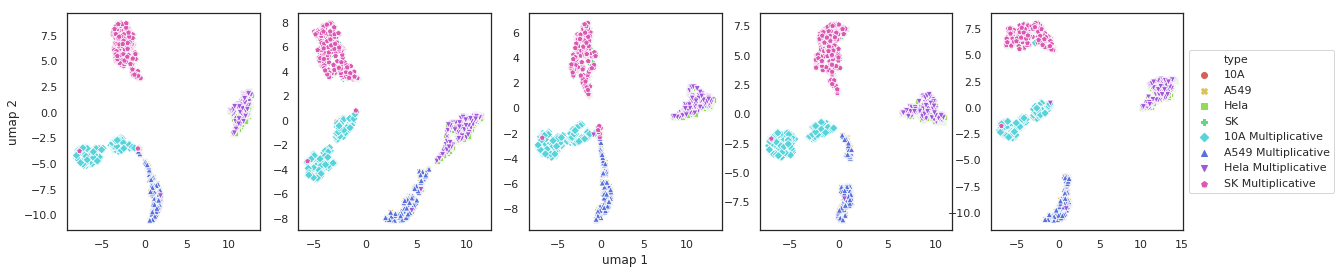

5 0
5 1
5 2
5 3
5 4


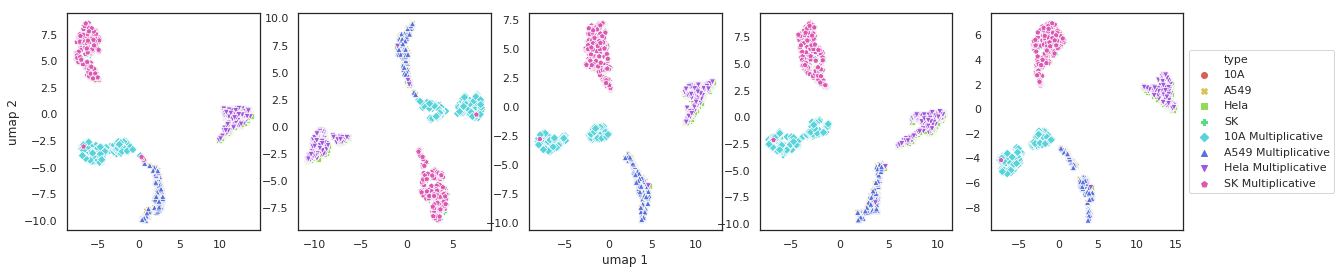

6 0
6 1
6 2
6 3
6 4


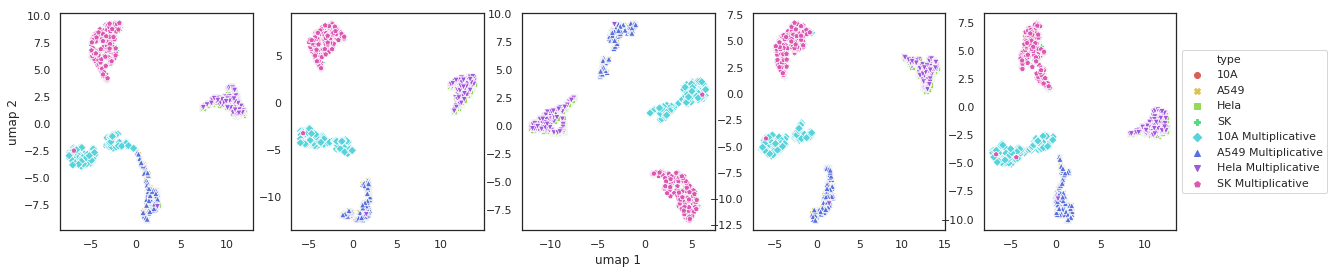

7 0
7 1
7 2
7 3
7 4


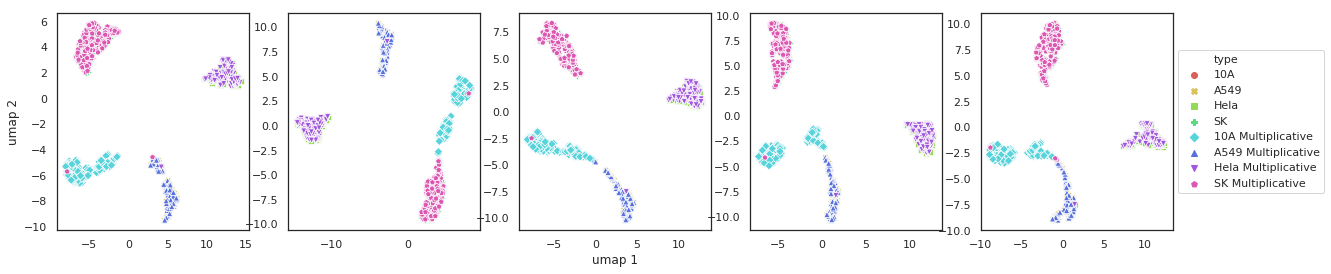

8 0
8 1
8 2
8 3
8 4


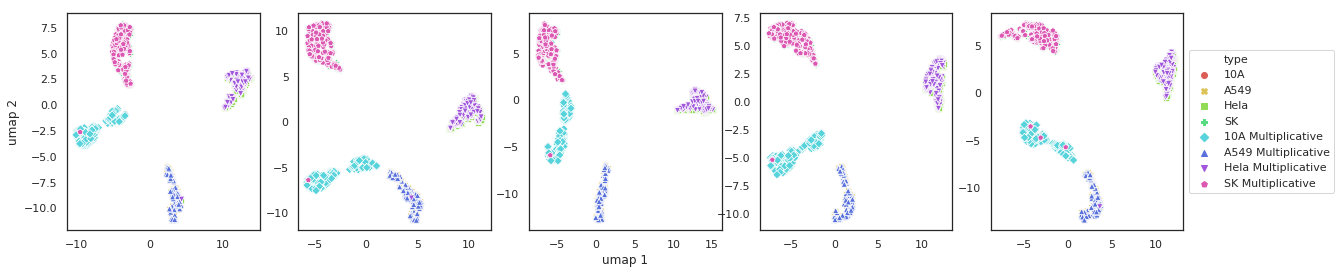

9 0
9 1
9 2
9 3
9 4


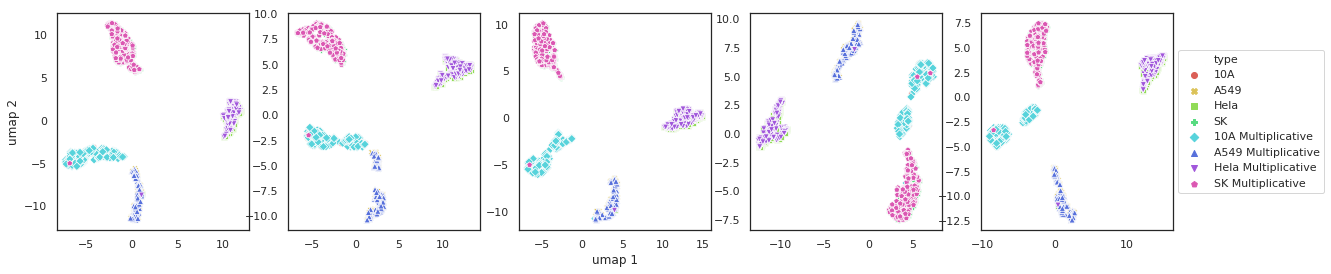

10 0
10 1
10 2
10 3
10 4


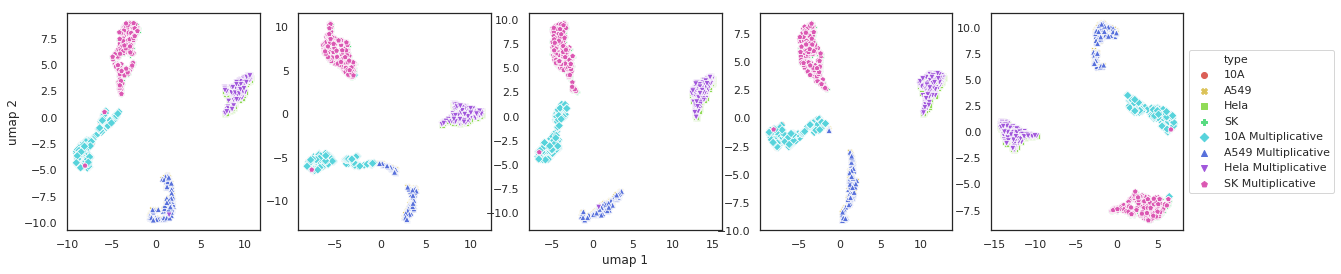

In [194]:
cat_map = {
    1:'10A',
    2:'A549',
    3:'Hela',
    4:'SK',
    5:'10A Multiplicative',
    6:'A549 Multiplicative',
    7:'Hela Multiplicative',
    8:'SK Multiplicative'
#     5:'10A Add zeros',
#     6:'A549 Add zeros',
#     7:'Hela Add zeros',
#     8:'SK Add zeros'
}
%matplotlib inline
sns.set()
sns.set_style("white")
sns.set_palette("hls")
# noisy_pixel_perc_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
# noisy_pixel_perc_list = [0.9,1.0]
noisy_pixel_perc_list = [1,2,3,4,5,6,7,8,9,10]



for noisy_perc in noisy_pixel_perc_list:
    cur_true_y = data_dump[noisy_perc]['true_y']
    plt.figure(figsize=(20,4))

    


    for i in range(5):
        if i==4:
            legend_flag = 'full'
        else:
            legend_flag = False
        print(noisy_perc,i)
        cur_rep = data_dump[noisy_perc]['rep'][i]
        cur_embed = umap.UMAP(n_components=2,metric='correlation',verbose=False).fit_transform(cur_rep)
        pd_dict = {
            'umap 1':cur_embed[:,0],
            'umap 2':cur_embed[:,1],
            
            'type':list(map(lambda a:cat_map[a],cur_true_y.astype('int')))



        }

        pd_data = pd.DataFrame(pd_dict)

        plt.subplot(1,5,i+1)
        sns.scatterplot(sizes=1000,x='umap 1',y='umap 2',hue='type',data=pd_data,style='type',palette=sns.hls_palette(8),legend=legend_flag)

        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True)
        if i!=2:
            plt.xlabel('')
        if i!=0:
            plt.ylabel('')
    
    plt.savefig("Cellline_randmul{noisy_perc}_umap_1029.svg".format(noisy_perc=noisy_perc))
    plt.show()
    




/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


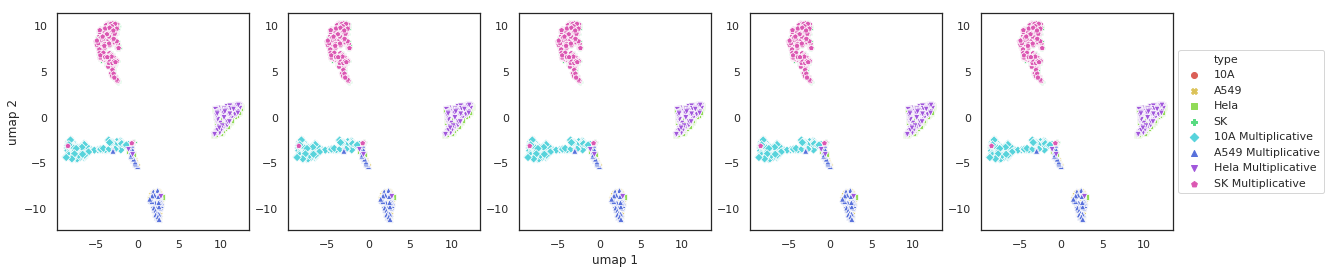

In [102]:
plt.figure(figsize=(20,4))


for i in range(5):
    if i==4:
        legend_flag = 'full'
    else:
        legend_flag = False

    plt.subplot(1,5,i+1)
    sns.scatterplot(sizes=1000,x='umap 1',y='umap 2',hue='type',data=pd_data,style='type',palette=sns.hls_palette(8),legend=legend_flag)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fanc)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),fancybox=True)
    if i!=2:
        plt.xlabel('')
    if i!=0:
        plt.ylabel('')
#     plt.xlabel('')
#     plt.savefig("AB-H_randmul{noisy_perc}_umap.svg".format(noisy_perc=noisy_perc))
plt.savefig("AB-H_randmul{noisy_perc}_umap.svg".format(noisy_perc=noisy_perc))


plt.show()



In [83]:
a=sns.hls_palette(4)
b=sns.hls_palette(4, l=.3, s=.8)
a.extend(b)
sns.set_palette(a)

In [ ]:
%matplotlib inline
sns.set()
sns.set_style("white")
sns.set_palette("hls")
noisy_pixel_perc_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
# noisy_pixel_perc_list = [0.1]



for noisy_perc in noisy_pixel_perc_list:
    cur_true_y = data_dump[noisy_perc]['true_y']
    plt.figure(figsize=(50,10))


    for i in range(5):
        print(noisy_perc,i)
        cur_rep = data_dump[noisy_perc]['rep'][i]
        cur_embed = umap.UMAP(n_components=2,metric='correlation',verbose=False).fit_transform(cur_rep)
        pd_dict = {
            'softmax_embed_0':cur_embed[:,0],
            'softmax_embed_1':cur_embed[:,1],
            
            'type':list(map(lambda a:'celltype '+str(a),cur_true_y.astype('int')))



        }

        pd_data = pd.DataFrame(pd_dict)

        
        plt.subplot(1,5,i+1)
        sns.scatterplot(sizes=1000,x='softmax_embed_0',y='softmax_embed_1',hue='type',data=pd_data,style='type',palette='hls',legend='full')
    plt.show()



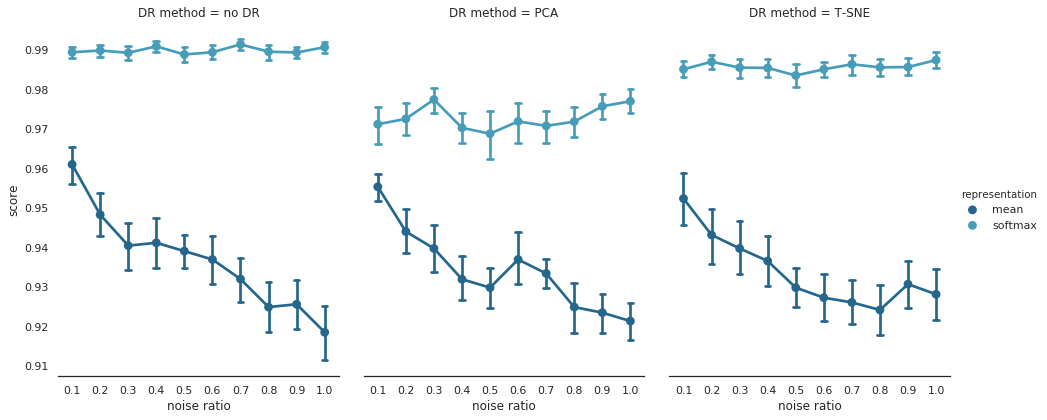

In [609]:
# cell line randomly add zeros


# rst_dump = pickle.load(open('cellline_randadd_rst.pkl','rb'))


alg_map = {
    'a':'mean',
    'b':'softmax',
    'c':'mean+pca',
    'd':'softmax+pca',
    'e':'mean+tsne',
    'f':'softmax+tsne'
}
pd_dict = {
    'alg':[],
    'noise ratio':[],
    'score':[],
    'DR method':[],
    'representation':[]
}
for alg,val in rst_dump.items():
    for noise_ratio,score_mat in val.items():
        score_mat = np.array(score_mat)
        score_mat = score_mat.flatten()
        for score in score_mat:
            pd_dict['alg'].append(alg_map[alg])
            pd_dict['noise ratio'].append(noise_ratio)
            pd_dict['score'].append(score)
            if alg=='a' or alg=='b':
                pd_dict['DR method'].append('no DR')
            elif alg=='c' or alg=='d':
                pd_dict['DR method'].append('PCA')
            elif alg=='e' or alg=='f':
                pd_dict['DR method'].append('T-SNE')
            
            if alg in ['a','c','e']:
                pd_dict['representation'].append('mean')
            elif alg in ['b','d','f']:
                pd_dict['representation'].append('softmax')

pd_data = pd.DataFrame(pd_dict)
g = sns.catplot(x="noise ratio", y="score", hue="representation",col='DR method',
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=pd_data)
g.despine(left=True)

            
    

In [146]:
rst_dump = pickle.load(open('cellline_randmul_rst_randmul2_1025.pkl','rb'))



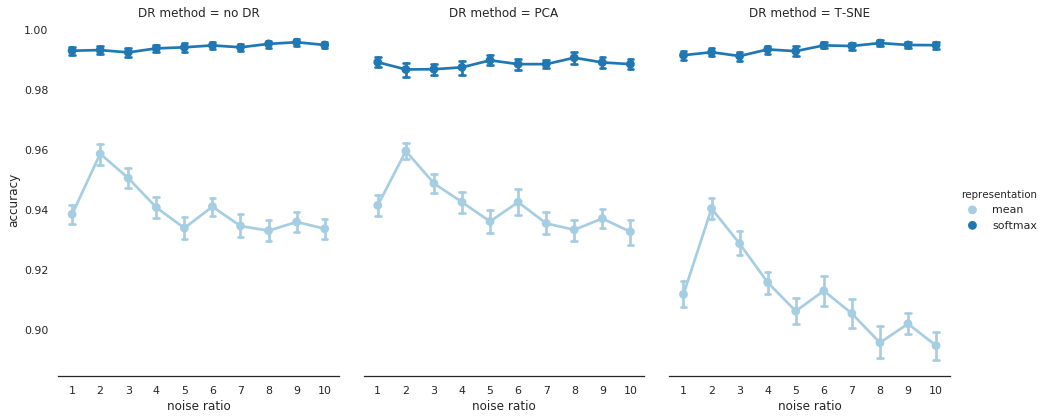

In [149]:
# cell line randomly mul

sns.set(style='white')


alg_map = {
    'a':'mean',
    'b':'softmax',
    'c':'mean+pca',
    'd':'softmax+pca',
    'e':'mean+tsne',
    'f':'softmax+tsne'
}
pd_dict = {
    'alg':[],
    'noise ratio':[],
    'accuracy':[],
    'DR method':[],
    'representation':[]
}
for alg,val in rst_dump.items():
    for noise_ratio,score_mat in val.items():
        score_mat = np.array(score_mat)
        score_mat = score_mat.flatten()
        for score in score_mat:
            pd_dict['alg'].append(alg_map[alg])
            pd_dict['noise ratio'].append(noise_ratio)
            pd_dict['accuracy'].append(score)
            if alg=='a' or alg=='b':
                pd_dict['DR method'].append('no DR')
            elif alg=='c' or alg=='d':
                pd_dict['DR method'].append('PCA')
            elif alg=='e' or alg=='f':
                pd_dict['DR method'].append('T-SNE')
            
            if alg in ['a','c','e']:
                pd_dict['representation'].append('mean')
            elif alg in ['b','d','f']:
                pd_dict['representation'].append('softmax')

pd_data = pd.DataFrame(pd_dict)
g = sns.catplot(x="noise ratio", y="accuracy", hue="representation",col='DR method',
                capsize=.2, palette="Paired", height=6, aspect=.75,
                kind="point", data=pd_data)
g.despine(left=True)
plt.savefig('Cellline_randmul_rst.svg',transparent=True,format='svg')


            
    